# Assignment 3 V2

First, 2 datasets -> 2 Clustering Algorithms
Next, reduce datasets using DRAs
All 8 DR-datasets -> 2 Clustering Algorithms (Report one of the DRAs and manifold for each dataset for 4 demonstrations.)
Choose one dataset and rerun A1 NN with each DRA. (Report on one of the DRAs and manifold performance for 2 total demonstrations.)
Using dataset from 4, use clusters from 1 as a new feature. Rerun the NN using each set of clusters

1. Pick two datasets 
2. Configure EM and KMeans (clalgs)
3. Run test on both clalgs to determine number of clusters - use yellowbrick and silhouette
4. Run these datasets on the two clustering algorihms using optimal clusters
5. Viz using tSNE against the true output

6. Configure all DRAs
7. Run datasets on these the DRAs
8. Viz using tSNE vs orig data

9. Choose num clusters
10. For PCA, look at eigenvalues to pick nclusters
11. For ICA, look at kurtosis to pick nclusters
12. For RP, look at reconstruction error
9. Run these 8 datasets on the clustering algorithms
10. Select which to report on
11. Viz

12. Configure NN model
13. Run all DR-datasets on NN model
14. Select which to report on

15. Using same dataset as (14), run NN model with cluster outputs from (3) as features
16. Viz


In [166]:
# Imports

import sklearn
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import yellowbrick.cluster
import scipy
import pandas as pd
import seaborn as sn
import time

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection

from sklearn.datasets import load_breast_cancer #(569, 30, 2)
from sklearn.datasets import load_digits #(1797, 64, 10)

from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score

from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import MinMaxScaler

from yellowbrick.cluster import KElbowVisualizer

from scipy.stats import kurtosis

from sklearn.neural_network import MLPClassifier


### Selecting Datasets

In [2]:
# Creating datasets

dataset1 = load_breast_cancer()
dataset2 = load_digits()

data1 = dataset1.data
data2 = dataset2.data

target1 = dataset1.target
target2 = dataset2.target

data1_train, data1_test, target1_train, target1_test = train_test_split(data1, target1, test_size=0.3, random_state=1)
data2_train, data2_test, target2_train, target2_test = train_test_split(data2, target2, test_size=0.3, random_state=1)

numTargets1 = np.unique(target1).size
numTargets2 = np.unique(target2).size

numSamples1 = data1_train.shape[0]
numSamples2 = data2_train.shape[0]

numFeatures1 = data1_train.shape[1]
numFeatures2 = data2_train.shape[1]

nSearch1 = int(np.sqrt(numSamples1))
nSearch2 = int(np.sqrt(numSamples2))

dataname1 = "Breast Cancer Data"
dataname2 = "Digit Data"

Text(0.5, 1.0, 'Digit Data')

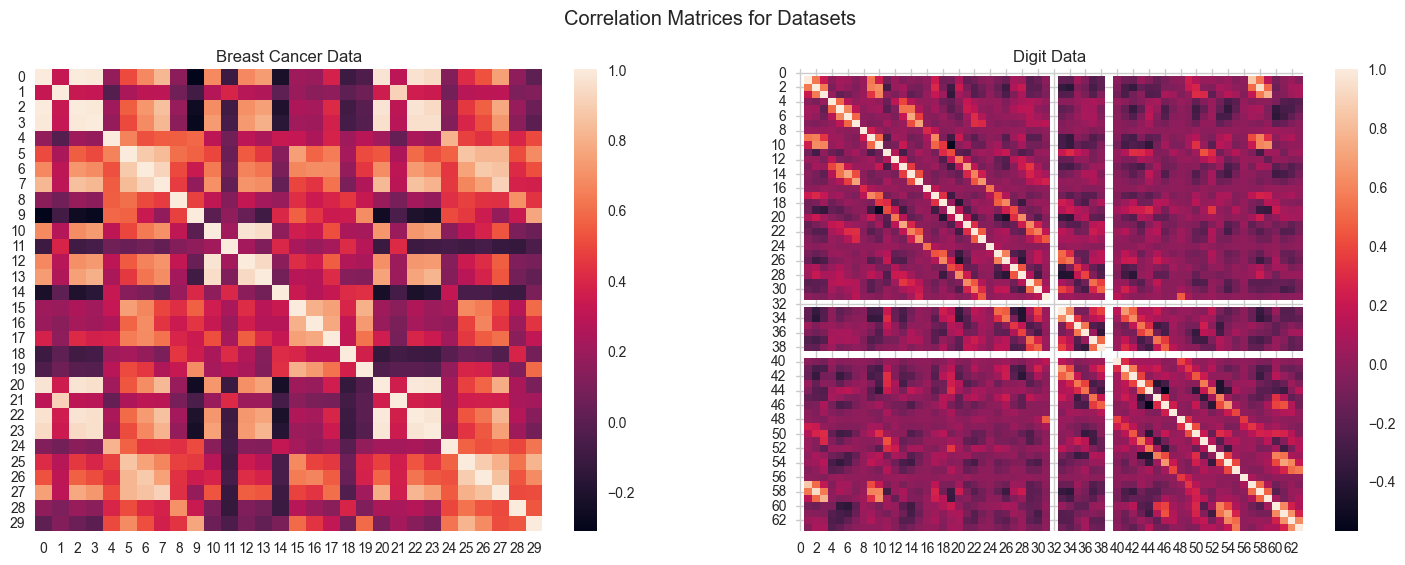

In [3]:
# Dataset 2
df1 = pd.DataFrame(data1).corr()
df2 = pd.DataFrame(data2).corr()

fig,  (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)
sn.heatmap(df1, ax=ax1)
sn.heatmap(df2, ax=ax2)
fig.suptitle('Correlation Matrices for Datasets')
ax1.set_title(dataname1)
ax2.set_title(dataname2)

### Correlation Matrix Eval

In [4]:
# Net Correlation
print((np.sum(pd.DataFrame.to_numpy(abs(df1))[~np.isnan(df1)]) - numFeatures1)/2/numFeatures1/numFeatures1)
print((np.sum(pd.DataFrame.to_numpy(abs(df2))[~np.isnan(df2)]) - numFeatures2)/2/numFeatures2/numFeatures2)

0.19086670235685768
0.054844981183734196


### Selecting Number of components

C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

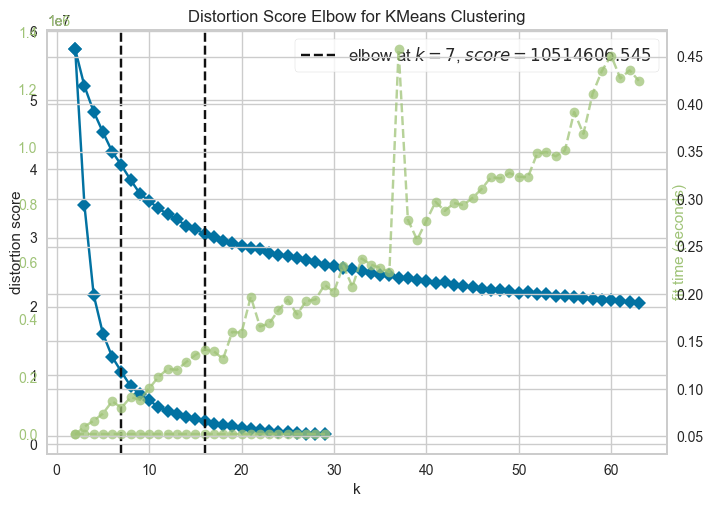

7
16


In [5]:
# Selecting k for kMeans

startIndex = 2

model = KMeans()
visualizer1 = KElbowVisualizer(model, k=(startIndex, numFeatures1))
visualizer2 = KElbowVisualizer(model, k=(startIndex, numFeatures2))

visualizer1.fit(data1_train)
visualizer2.fit(data2_train)

visualizer1.show()
visualizer2.show()

k1 = visualizer1.elbow_value_
k2 = visualizer2.elbow_value_

print(k1)
print(k2)

In [6]:
# Select n_comp for GMM
def gmm_sil_score(estimator, X):
    return silhouette_score(X, estimator.fit_predict(X))

mm_data1 = MinMaxScaler().fit_transform(data1_train)
mm_data2 = MinMaxScaler().fit_transform(data2_train)

nums1 = np.zeros(numFeatures1)
nums2 = np.zeros(numFeatures2)

param_grid1 = {"n_components" : range(2, numFeatures1)}
grid_search1 = GridSearchCV(GaussianMixture(), param_grid=param_grid1, scoring=gmm_sil_score)
grid_search1.fit(mm_data1)

param_grid2 = {"n_components" : range(2, numFeatures2)}
grid_search2 = GridSearchCV(GaussianMixture(), param_grid=param_grid2, scoring=gmm_sil_score)
grid_search2.fit(mm_data2)

gmm1 = grid_search1.best_params_['n_components']
gmm2 = grid_search2.best_params_['n_components']

print(grid_search1.best_score_)
print(grid_search2.best_score_)

print(gmm1)
print(gmm2)

0.3881702717791199
0.1754655042518718


In [31]:
print(gmm2)

11


### Configuring Clustering Algorithms

In [8]:
# Configure EM
em1 = GaussianMixture(n_components=gmm1, random_state=1).fit(data1_train)
em2 = GaussianMixture(n_components=gmm2, random_state=1).fit(data2_train)

In [9]:
# Configure k-Means
km1 = KMeans(n_clusters=k1).fit(data1_train)
km2 = KMeans(n_clusters=k2).fit(data2_train)

C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [71]:
# Make Predictions
em1Pred = em1.predict(data1_train)
em2Pred = em2.predict(data2_train)

km1Pred = km1.predict(data1_train)
km2Pred = km2.predict(data2_train)

em1Pred_test = em1.predict(data1_test)
em2Pred_test = em2.predict(data2_test)

km1Pred_test = km1.predict(data1_test)
km2Pred_test = km2.predict(data2_test)

In [12]:
# Calculate Model Accuracy
em1Accuracy = homogeneity_score(em1Pred, target1_train)
em2Accuracy = homogeneity_score(em2Pred, target2_train)

km1Accuracy = homogeneity_score(km1Pred, target1_train)
km2Accuracy = homogeneity_score(km2Pred, target2_train)

print(em1Accuracy, em2Accuracy)
print(km1Accuracy, km2Accuracy)

0.5266541631054941 0.7400813320387358
0.27352187780483206 0.7163367722905876


Text(0, 0.5, 'axis 8')

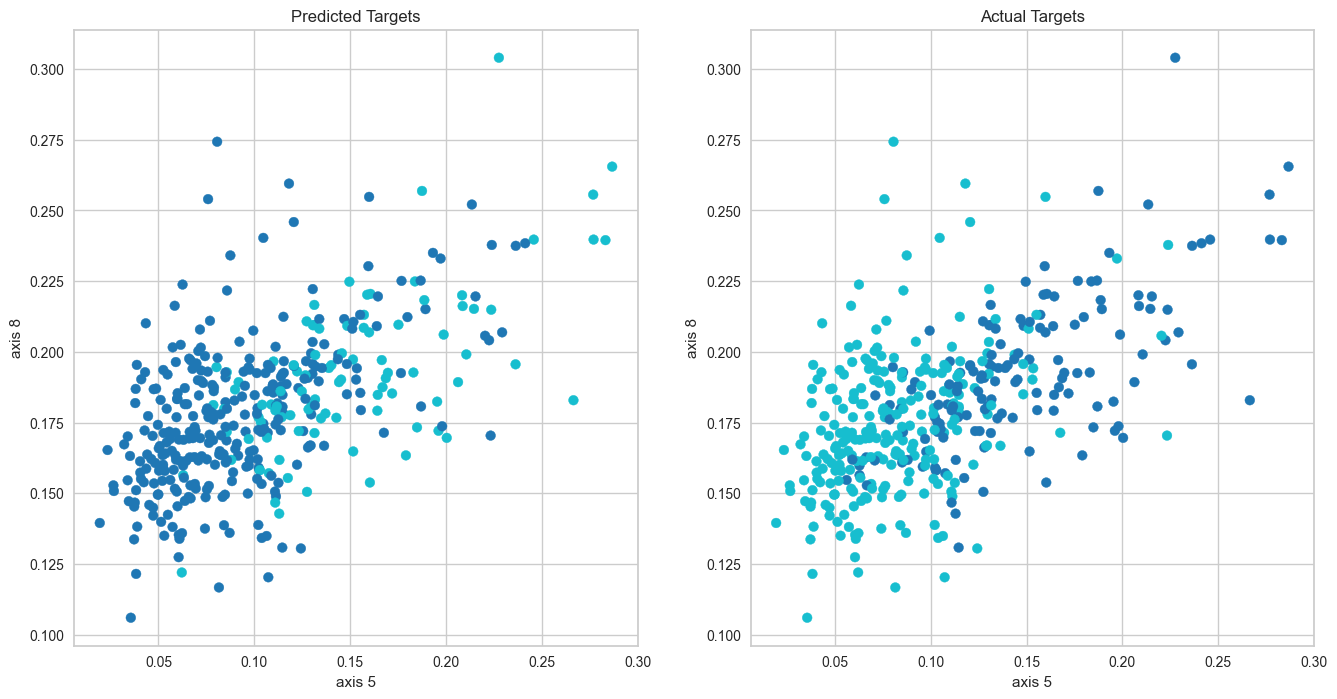

In [13]:
# Basic 2-D Viz
colors = em1Pred

figData = data1_train
figTarget = target1_train
axis1 = 5
axis2 = 8

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
ax.scatter(figData.T[axis1].T, figData.T[axis2].T, c=colors, cmap='tab10')
ax.set_title("Predicted Targets")
ax.set_xlabel("axis " + str(axis1))
ax.set_ylabel("axis " + str(axis2))

ax2 = fig.add_subplot(122)
ax2.scatter(figData.T[axis1].T, figData.T[axis2].T, c=figTarget, cmap='tab10')
ax2.set_title("Actual Targets")
ax2.set_xlabel("axis " + str(axis1))
ax2.set_ylabel("axis " + str(axis2))

Text(0, 0.5, 'axis 1')

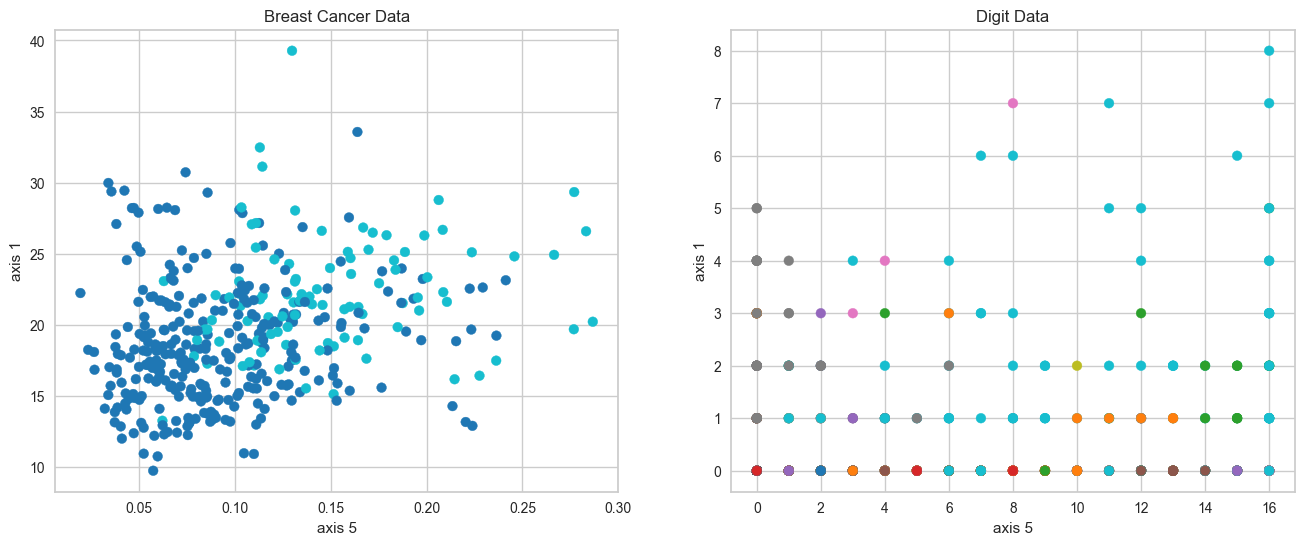

In [14]:
# Basic 2-D Viz V2
colors1 = em1Pred
colors2 = em2Pred

figData1 = data1_train
figData2 = data2_train
axis1 = 5
axis2 = 1

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.scatter(figData1.T[axis1].T, figData1.T[axis2].T, c=colors1, cmap='tab10')
ax.set_title(dataname1)
ax.set_xlabel("axis " + str(axis1))
ax.set_ylabel("axis " + str(axis2))

ax2 = fig.add_subplot(122)
ax2.scatter(figData2.T[axis1].T, figData2.T[axis2].T, c=colors2, cmap='tab10')
ax2.set_title(dataname2)
ax2.set_xlabel("axis " + str(axis1))
ax2.set_ylabel("axis " + str(axis2))

### Dimension Reduction Algorithms

In [15]:
# PCA scoring with explained variance
def pca_score(estimator, X):
    estimator.fit_transform(X)
    return estimator.explained_variance_ratio_.cumsum()

thresh1 = 0.95
dims_pca1 = 0
dims_pca2 = 0

evSum1 = np.zeros(numFeatures1 - startIndex)
evSum2 = np.zeros(numFeatures2 - startIndex)

for i in range(startIndex, numFeatures1):
    ev = pca_score(PCA(n_components=i), data1_train)
    evSum1[i - startIndex] = ev[-1]
    if ev[-1] > thresh1 and dims_pca1 == 0:
        dims_pca1 = i

for i in range(startIndex, numFeatures2):
    ev = pca_score(PCA(n_components=i), data2_train)
    evSum2[i - startIndex] = ev[-1]
    if ev[-1] > thresh1 and dims_pca2 == 0:
        dims_pca2 = i
print(dims_pca1)
print(dims_pca2)

2
29


Text(0, 0.5, 'Explained Variance Ratio Cumulative Sum')

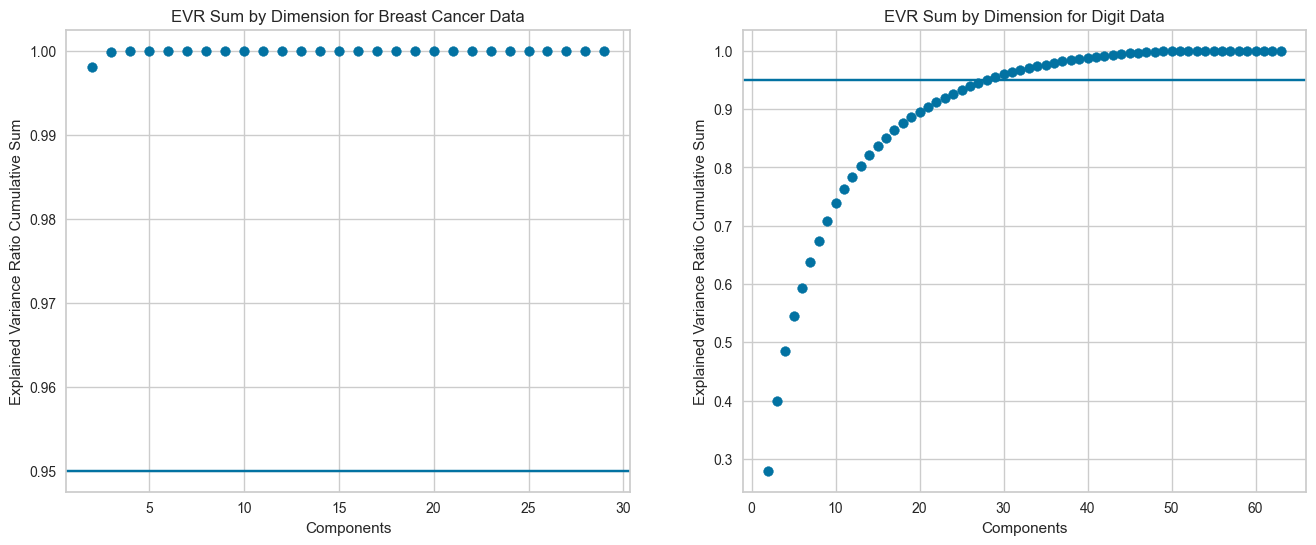

In [16]:
# Explained Variance Viz
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.scatter(np.arange(evSum1.size) + 2, evSum1)
ax.axhline(y=thresh1)
ax.set_title("EVR Sum by Dimension for " + dataname1)
ax.set_xlabel("Components")
ax.set_ylabel("Explained Variance Ratio Cumulative Sum")

ax2 = fig.add_subplot(122)
ax2.scatter(np.arange(evSum2.size) + 2, evSum2)
ax2.axhline(y=thresh1)
ax2.set_title("EVR Sum by Dimension for " + dataname2)
ax2.set_xlabel("Components")
ax2.set_ylabel("Explained Variance Ratio Cumulative Sum")

In [62]:
# Configure PCA
pca_data1 = PCA(n_components=dims_pca1).fit_transform(data1_train)
pca_data2 = PCA(n_components=dims_pca2).fit_transform(data2_train)

pca_data1_test = PCA(n_components=dims_pca1).fit_transform(data1_test)
pca_data2_test = PCA(n_components=dims_pca2).fit_transform(data2_test)

In [18]:
# ICA scoring with kurtosis
def kurtosis_score(estimator, comps, X):
    return np.mean(np.abs(kurtosis(estimator(n_components=comps).fit_transform(X))))

kurtosisScores1 = np.zeros(numFeatures1 - startIndex)
for i in range(startIndex, numFeatures1):
    kurtosisScores1[i - startIndex] = kurtosis_score(FastICA, i, data1_train)

kurtosisScores2 = np.zeros(numFeatures2 - startIndex)
for i in range(startIndex, numFeatures2):
    kurtosisScores2[i - startIndex] = kurtosis_score(FastICA, i, data2_train)

dims_ica1 = np.argmax(kurtosisScores1) + startIndex
dims_ica2 = np.argmax(kurtosisScores2) + startIndex

print(dims_ica1)
print(dims_ica2)

C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_q

3
60


C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Text(0, 0.5, 'Kurtosis')

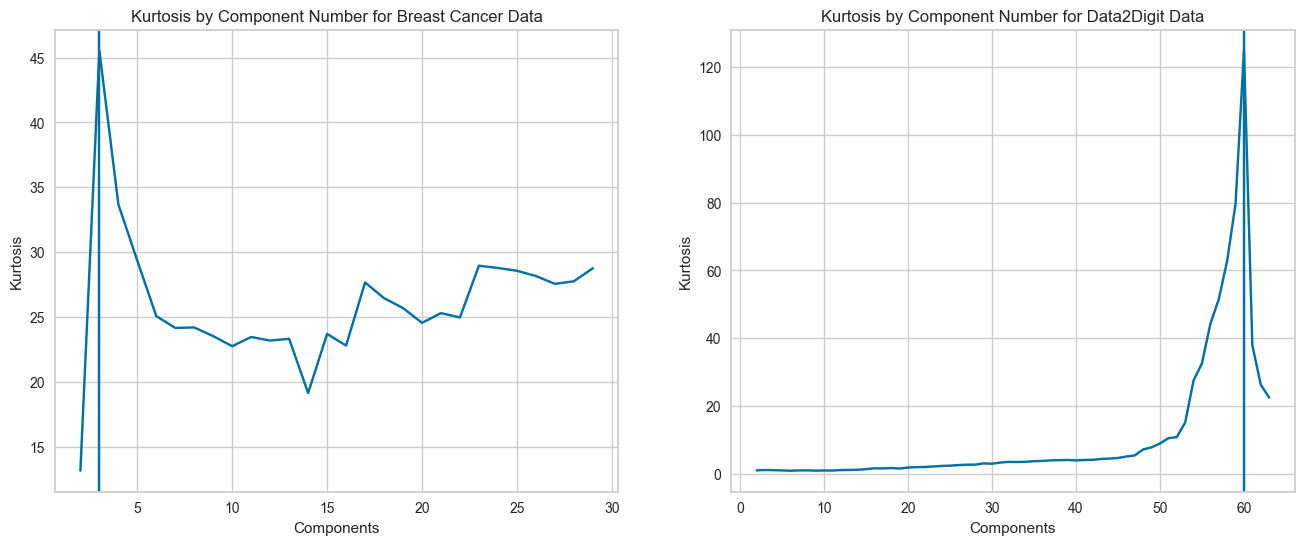

In [19]:
# Kurtosis Viz
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.plot(np.arange(kurtosisScores1.size) + startIndex, kurtosisScores1)
ax.axvline(dims_ica1)
ax.set_title("Kurtosis by Component Number for " + dataname1)
ax.set_xlabel("Components")
ax.set_ylabel("Kurtosis")

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(kurtosisScores2.size) + startIndex, kurtosisScores2)
ax2.axvline(dims_ica2)
ax2.set_title("Kurtosis by Component Number for Data2" + dataname2)
ax2.set_xlabel("Components")
ax2.set_ylabel("Kurtosis")

In [63]:
# Configure ICA
ica_data1 = FastICA(n_components=dims_ica1).fit_transform(data1_train)
ica_data2 = FastICA(n_components=dims_ica2).fit_transform(data2_train)

ica_data1_test = FastICA(n_components=dims_ica1).fit_transform(data1_test)
ica_data2_test = FastICA(n_components=dims_ica2).fit_transform(data2_test)

C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [21]:
# Configure Reconstruction Score Scorer
randomStates = [1, 2, 3, 4, 5]
def reconstruction_score(m, n, X):
    totalLoss = 0
    for rs in randomStates:
        model = m(n_components=n, compute_inverse_components=True, random_state=rs)
        model.fit(X)
        trained = model.transform(X)
        data_projected = np.matmul(X, model.inverse_components_)
        totalLoss += np.sum((trained - data_projected) ** 2, axis=1).mean()
    return totalLoss / len(randomStates)

In [22]:
# Calculate Reconstruction Score
reconstructionScores1 = np.zeros(numFeatures1 - startIndex)
for i in range(startIndex, numFeatures1):
    reconstructionScores1[i - startIndex] = reconstruction_score(GaussianRandomProjection, i, data1_train)

reconstructionScores2 = np.zeros(numFeatures2 - startIndex)
for i in range(startIndex, numFeatures2):
    reconstructionScores2[i - startIndex] = reconstruction_score(GaussianRandomProjection, i, data2_train)

dims_rp1 = np.argmin(reconstructionScores1) + startIndex
dims_rp2 = np.argmin(reconstructionScores2) + startIndex
print(dims_rp1)
print(dims_rp2)

4
25


Text(0, 0.5, 'Reconstruction Loss')

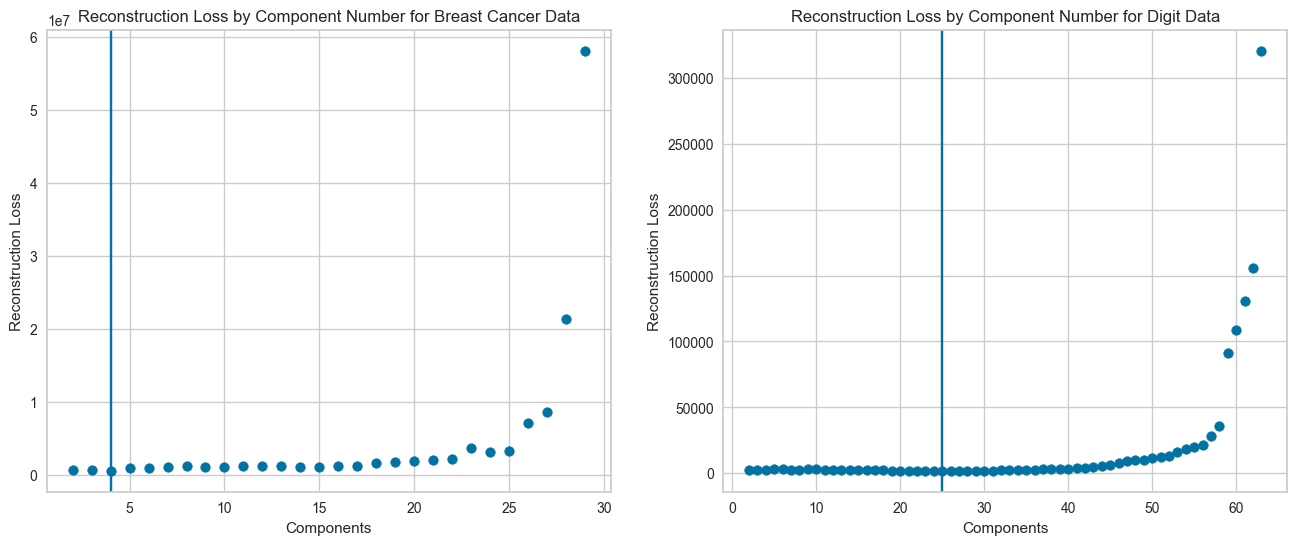

In [23]:
# Reconstruction Loss Viz
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.scatter(np.arange(reconstructionScores1.size) + startIndex, reconstructionScores1)
ax.axvline(dims_rp1)
ax.set_title("Reconstruction Loss by Component Number for " + dataname1)
ax.set_xlabel("Components")
ax.set_ylabel("Reconstruction Loss")

ax2 = fig.add_subplot(122)
ax2.scatter(np.arange(reconstructionScores2.size) + startIndex, reconstructionScores2)
ax2.axvline(dims_rp2)
ax2.set_title("Reconstruction Loss by Component Number for " + dataname2)
ax2.set_xlabel("Components")
ax2.set_ylabel("Reconstruction Loss")

In [64]:
# Configure Random Projections
rp_data1 = GaussianRandomProjection(n_components=dims_rp1).fit_transform(data1_train)
rp_data2 = GaussianRandomProjection(n_components=dims_rp2).fit_transform(data2_train)

rp_data1_test = GaussianRandomProjection(n_components=dims_rp1).fit_transform(data1_test)
rp_data2_test = GaussianRandomProjection(n_components=dims_rp2).fit_transform(data2_test)

In [25]:
# Find Parameters for Iso
rscores1 = np.zeros(numFeatures1 - startIndex)
for i in range(startIndex, numFeatures1):
    model = Isomap(n_components=i)
    model.fit(data1_train)
    trans = model.transform(data1_train)
    rscores1[i - startIndex] = model.reconstruction_error()

rscores2 = np.zeros(numFeatures2 - startIndex)
for i in range(startIndex, numFeatures2):
    model = Isomap(n_components=i)
    model.fit(data2_train)
    trans = model.transform(data2_train)
    rscores2[i - startIndex] = model.reconstruction_error()

Text(0, 0.5, 'Reconstruction Score')

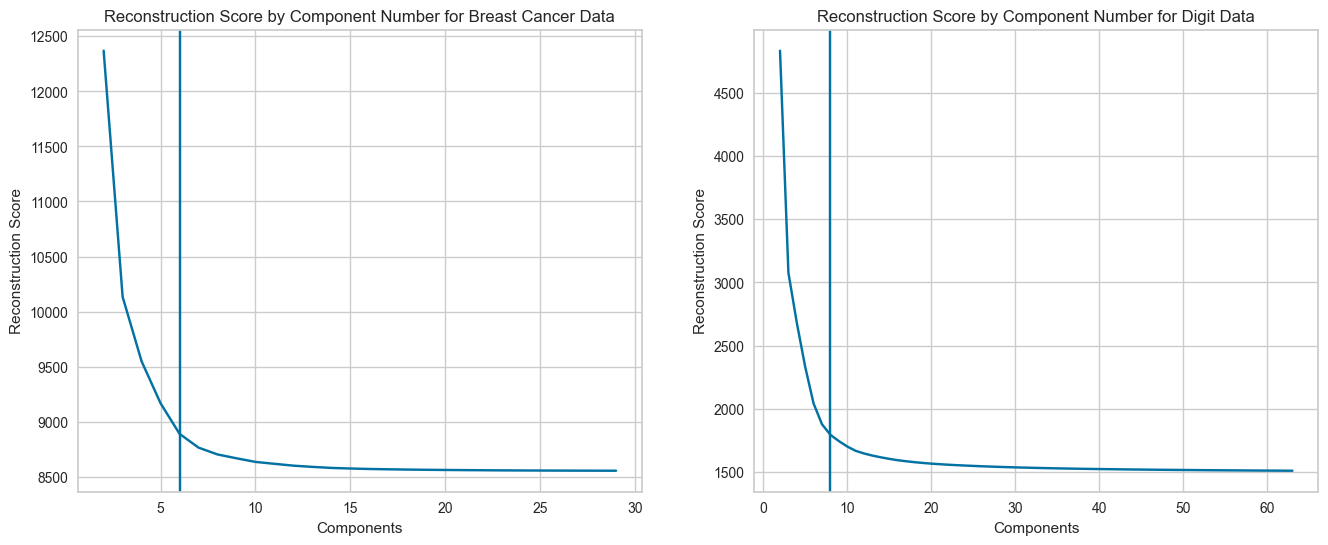

In [27]:
# Viz Reconstruction error
dims_iso1 = 6
dims_iso2 = 8
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.plot(np.arange(len(rscores1)) + startIndex, rscores1)
ax.axvline(x=dims_iso1)
ax.set_title("Reconstruction Score by Component Number for " + dataname1)
ax.set_xlabel("Components")
ax.set_ylabel("Reconstruction Score")

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(len(rscores2)) + startIndex, rscores2)
ax2.axvline(x=dims_iso2)
ax2.set_title("Reconstruction Score by Component Number for " + dataname2)
ax2.set_xlabel("Components")
ax2.set_ylabel("Reconstruction Score")

In [65]:
# Reduce using Isomap
iso_data1 = Isomap(n_components=dims_iso1).fit_transform(data1_train)
iso_data2 = Isomap(n_components=dims_iso2).fit_transform(data2_train)

iso_data1_test = Isomap(n_components=dims_iso1).fit_transform(data1_test)
iso_data2_test = Isomap(n_components=dims_iso2).fit_transform(data2_test)

In [29]:
# Num dimensions
print("Num dimensions in data after DRA:")
print("Orig: ", numFeatures1, numFeatures2)
print("PCA: ", dims_pca1, dims_pca2)
print("ICA: ", dims_ica1, dims_ica2)
print("RP: ", dims_rp1, dims_rp2)
print("ISO: ", dims_iso1, dims_iso2)

Num dimensions in data after DRA:
Orig:  30 64
PCA:  2 29
ICA:  3 60
RP:  4 25
ISO:  6 8


### Clustering on DRA's

C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

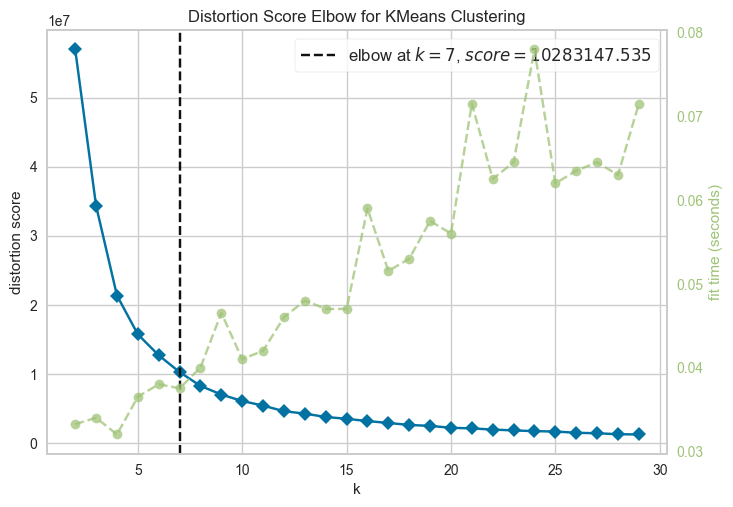

In [95]:
# Find n_components for kmeans, pca

model = KMeans()
visualizer_pca1 = KElbowVisualizer(model, k=(startIndex, numFeatures1))
visualizer_pca2 = KElbowVisualizer(model, k=(startIndex, numFeatures2))

visualizer_pca1.fit(pca_data1)
visualizer_pca2.fit(pca_data2)

visualizer_pca1.show()
visualizer_pca2.show()

k_pca1 = visualizer_pca1.elbow_value_
k_pca2 = visualizer_pca2.elbow_value_

C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

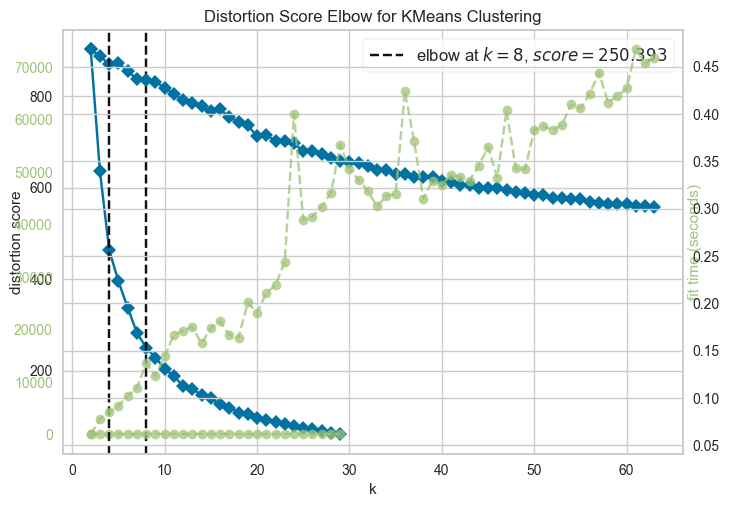

In [33]:
# Find n_components for kmeans, ica

visualizer_ica1 = KElbowVisualizer(model, k=(startIndex, numFeatures1))
visualizer_ica2 = KElbowVisualizer(model, k=(startIndex, numFeatures2))

visualizer_ica1.fit(ica_data1)
visualizer_ica2.fit(ica_data2)

visualizer_ica1.show()
visualizer_ica2.show()

k_ica1 = visualizer_ica1.elbow_value_
k_ica2 = visualizer_ica2.elbow_value_

C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

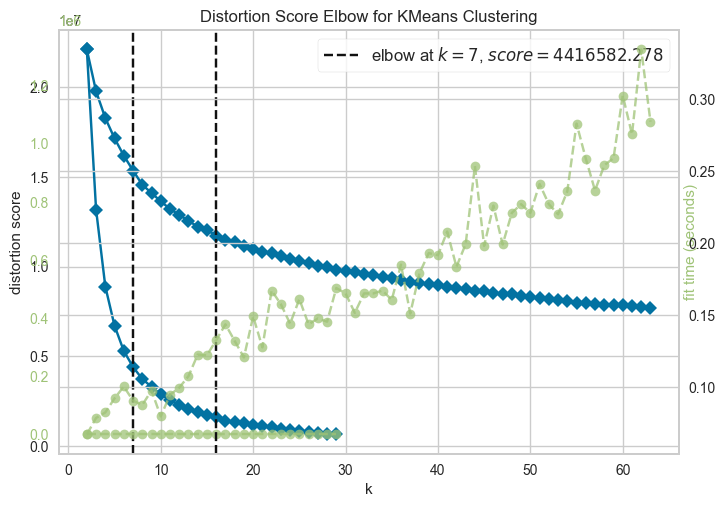

In [34]:
# Find n_components for kmeans, rp

visualizer_rp1 = KElbowVisualizer(model, k=(startIndex, numFeatures1))
visualizer_rp2 = KElbowVisualizer(model, k=(startIndex, numFeatures2))

visualizer_rp1.fit(rp_data1)
visualizer_rp2.fit(rp_data2)

visualizer_rp1.show()
visualizer_rp2.show()

k_rp1 = visualizer_rp1.elbow_value_
k_rp2 = visualizer_rp2.elbow_value_

C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

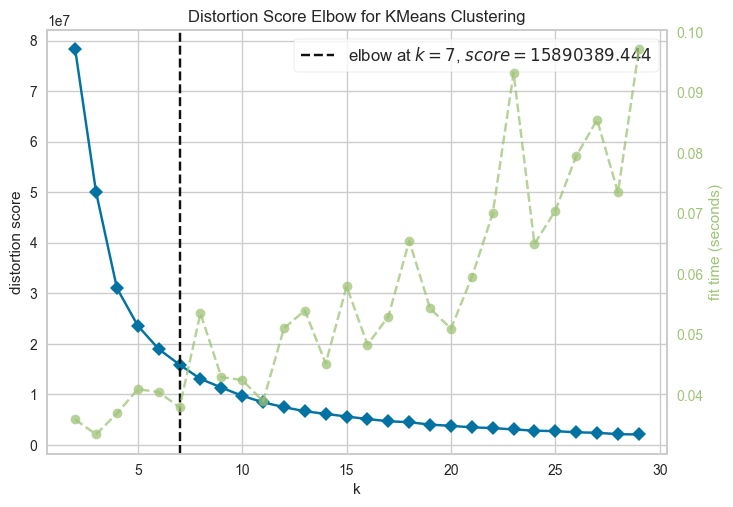

In [94]:
# Find n_components for kmeans, iso

visualizer_iso1 = KElbowVisualizer(model, k=(startIndex, numFeatures1))
visualizer_iso2 = KElbowVisualizer(model, k=(startIndex, numFeatures2))

visualizer_iso1.fit(iso_data1)
visualizer_iso2.fit(iso_data2)

visualizer_iso1.show()
visualizer_iso2.show()

k_iso1 = visualizer_iso1.elbow_value_
k_iso2 = visualizer_iso2.elbow_value_

In [116]:
# Select n_comp for GMM , pca
nums1 = np.zeros(numFeatures1)
nums2 = np.zeros(numFeatures2)

param_grid1 = {"n_components" : range(2, numFeatures1)}
pca_grid_search1 = GridSearchCV(GaussianMixture(), param_grid=param_grid1, scoring=gmm_sil_score)
pca_grid_search1.fit(pca_data1)

param_grid2 = {"n_components" : range(2, numFeatures2)}
pca_grid_search2 = GridSearchCV(GaussianMixture(), param_grid=param_grid2, scoring=gmm_sil_score)
pca_grid_search2.fit(pca_data2)

pca_gmm1 = pca_grid_search1.best_params_['n_components']
pca_gmm2 = pca_grid_search2.best_params_['n_components']

In [117]:
# Select n_comp for GMM , ica
nums1 = np.zeros(numFeatures1)
nums2 = np.zeros(numFeatures2)

param_grid1 = {"n_components" : range(2, numFeatures1)}
ica_grid_search1 = GridSearchCV(GaussianMixture(), param_grid=param_grid1, scoring=gmm_sil_score)
ica_grid_search1.fit(iso_data1)

param_grid2 = {"n_components" : range(2, numFeatures2)}
ica_grid_search2 = GridSearchCV(GaussianMixture(), param_grid=param_grid2, scoring=gmm_sil_score)
ica_grid_search2.fit(iso_data2)

ica_gmm1 = ica_grid_search1.best_params_['n_components']
ica_gmm2 = ica_grid_search2.best_params_['n_components']

In [118]:
# Select n_comp for GMM , rp
nums1 = np.zeros(numFeatures1)
nums2 = np.zeros(numFeatures2)

param_grid1 = {"n_components" : range(2, numFeatures1)}
rp_grid_search1 = GridSearchCV(GaussianMixture(), param_grid=param_grid1, scoring=gmm_sil_score)
rp_grid_search1.fit(rp_data1)

param_grid2 = {"n_components" : range(2, numFeatures2)}
rp_grid_search2 = GridSearchCV(GaussianMixture(), param_grid=param_grid2, scoring=gmm_sil_score)
rp_grid_search2.fit(rp_data2)

rp_gmm1 = rp_grid_search1.best_params_['n_components']
rp_gmm2 = rp_grid_search2.best_params_['n_components']

In [119]:
# Select n_comp for GMM , iso
nums1 = np.zeros(numFeatures1)
nums2 = np.zeros(numFeatures2)

param_grid1 = {"n_components" : range(2, numFeatures1)}
iso_grid_search1 = GridSearchCV(GaussianMixture(), param_grid=param_grid1, scoring=gmm_sil_score)
iso_grid_search1.fit(iso_data1)

param_grid2 = {"n_components" : range(2, numFeatures2)}
iso_grid_search2 = GridSearchCV(GaussianMixture(), param_grid=param_grid2, scoring=gmm_sil_score)
iso_grid_search2.fit(iso_data2)

iso_gmm1 = iso_grid_search1.best_params_['n_components']
iso_gmm2 = iso_grid_search2.best_params_['n_components']

In [120]:
print("Num Clusters in data: ")
print("Orig", numTargets1, numTargets2)
print("PCA, GMM: ", pca_gmm1, pca_gmm2)
print("PCA, KM: ", k_pca1, k_pca2)
print("ICA, GMM: ", ica_gmm1, ica_gmm2)
print("ICA, KM: ", k_ica1, k_ica2)
print("RP, GMM: ", rp_gmm1, rp_gmm2)
print("RP, KM: ", k_rp1, k_rp2)
print("iso, GMM: ", iso_gmm1, iso_gmm2)
print("iso, KM: ", k_iso1, k_iso2)

Num Clusters in data: 
Orig 2 10
PCA, GMM:  2 16
PCA, KM:  7 18
ICA, GMM:  2 9
ICA, KM:  8 4
RP, GMM:  2 9
RP, KM:  7 16
iso, GMM:  2 9
iso, KM:  7 11


In [167]:
pca_sil_score1 = np.zeros(numFeatures1 - startIndex)
iso_sil_score1 = np.zeros(numFeatures1 - startIndex)

pca_time1 = np.zeros(numFeatures1 - startIndex)
iso_time1 = np.zeros(numFeatures1 - startIndex)

for i in range(startIndex, numFeatures1):
    model = GaussianMixture(n_components=i)
    t = time.time()
    pca_sil_score1[i - startIndex] = silhouette_score(pca_data1, model.fit_predict(pca_data1))
    pca_time1[i - startIndex] = time.time() - t
    t = time.time()
    iso_sil_score1[i - startIndex] = silhouette_score(iso_data1, model.fit_predict(iso_data1))
    iso_time1[i - startIndex] = time.time() - t

pca_sil_score2 = np.zeros(numFeatures2 - startIndex)
iso_sil_score2 = np.zeros(numFeatures2 - startIndex)

pca_time2 = np.zeros(numFeatures2 - startIndex)
iso_time2 = np.zeros(numFeatures2 - startIndex)

for i in range(startIndex, numFeatures2):
    model = GaussianMixture(n_components=i)
    t = time.time()
    pca_sil_score2[i - startIndex] = silhouette_score(pca_data2, model.fit_predict(pca_data2))
    pca_time2[i - startIndex] = time.time() - t
    t = time.time()
    iso_sil_score2[i - startIndex] = silhouette_score(iso_data2, model.fit_predict(iso_data2))
    iso_time2[i - startIndex] = time.time() - t

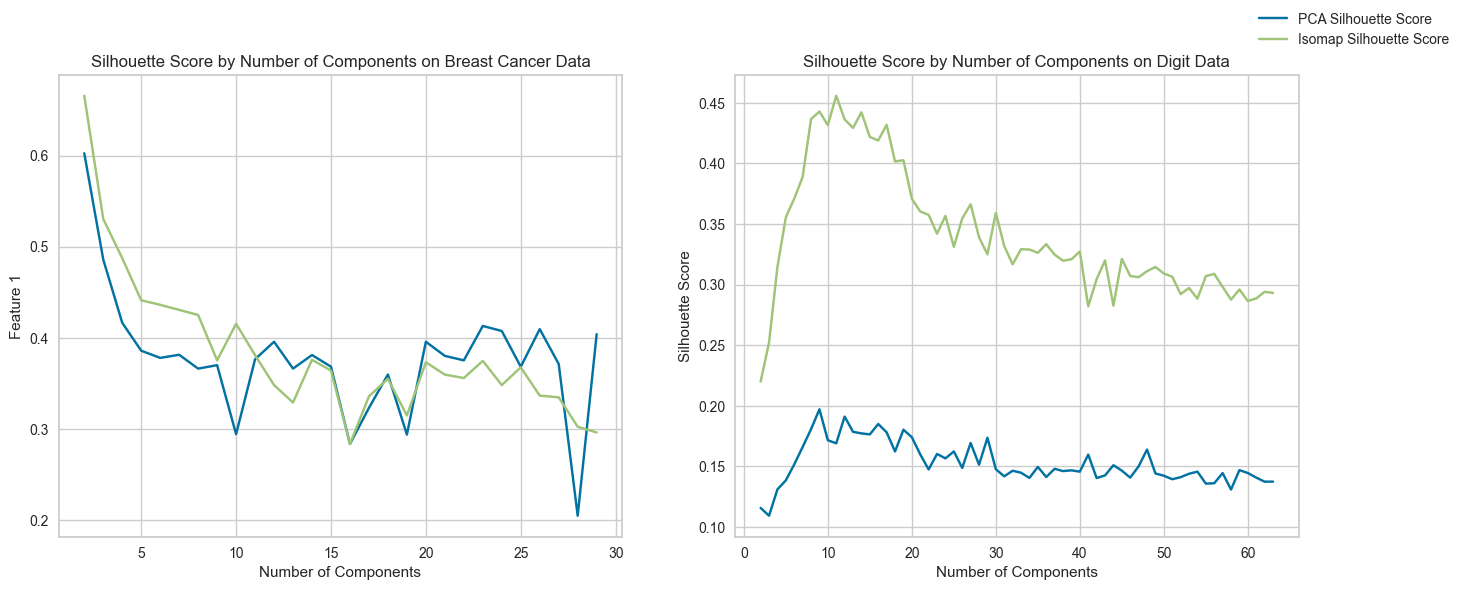

In [146]:
# Viz t-SNE selected data
fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(121)
ax.plot(np.arange(len(pca_sil_score1)) + startIndex, pca_sil_score1)
ax.plot(np.arange(len(iso_sil_score1)) + startIndex, iso_sil_score1)
ax.set_title("Silhouette Score by Number of Components on " + dataname1)
ax.set_xlabel("Number of Components")
ax.set_ylabel("Silhouette Score")

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(len(pca_sil_score2)) + startIndex, pca_sil_score2)
ax2.plot(np.arange(len(iso_sil_score2)) + startIndex, iso_sil_score2)
ax2.set_title("Silhouette Score by Number of Components on " + dataname2)
ax2.set_xlabel("Number of Components")
ax2.set_ylabel("Silhouette Score")

fig.legend(["PCA Silhouette Score", "Isomap Silhouette Score"])

Text(0.5, 1.0, 'Iso-Reduced Data Histogram')

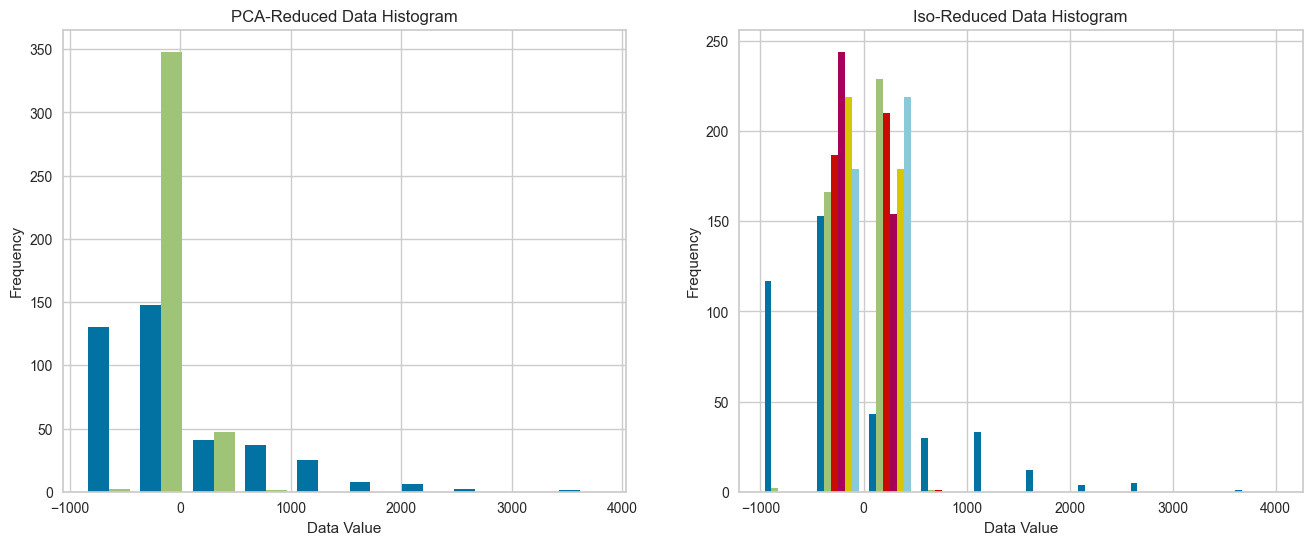

In [163]:
# Histogram of Analyzed Data
fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(121)
n, bins, patches = ax.hist(pca_data1)
ax.set_xlabel("Data Value")
ax.set_ylabel("Frequency")
ax.set_title("PCA-Reduced Data Histogram")

ax2 = fig.add_subplot(122)
n, bins, patches = ax2.hist(iso_data1)
ax2.set_xlabel("Data Value")
ax2.set_ylabel("Frequency")
ax2.set_title("Iso-Reduced Data Histogram")

In [164]:
print(np.std(pca_data1))
print(np.std(iso_data1))

502.90652010957484
335.9547681151522


Text(0, 0.5, 'Number of Clusters')

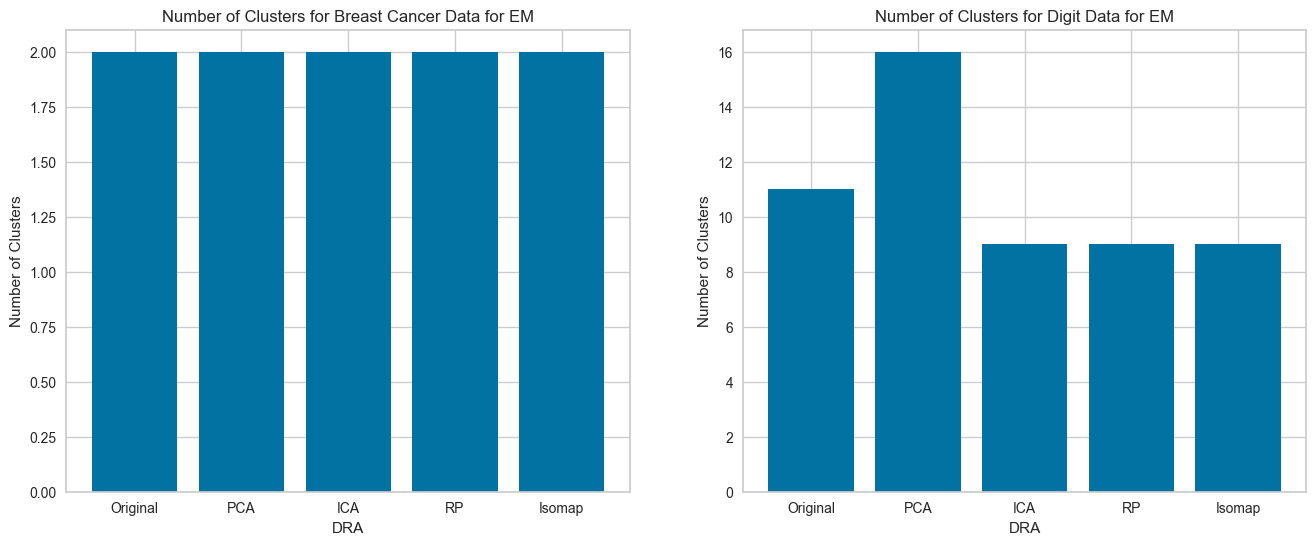

In [149]:
# Viz num clusters
fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(121)
ax.bar(["Original", "PCA", "ICA", "RP", "Isomap"], [gmm1, pca_gmm1, ica_gmm1, rp_gmm1, iso_gmm1])
ax.set_title("Number of Clusters for " + dataname1 + " for EM")
ax.set_xlabel("DRA")
ax.set_ylabel("Number of Clusters")

ax2 = fig.add_subplot(122)
ax2.bar(["Original", "PCA", "ICA", "RP", "Isomap"], [gmm2, pca_gmm2, ica_gmm2, rp_gmm2, iso_gmm2])
ax2.set_title("Number of Clusters for " + dataname2 + " for EM")
ax2.set_xlabel("DRA")
ax2.set_ylabel("Number of Clusters")

Text(0, 0.5, 'Number of Clusters')

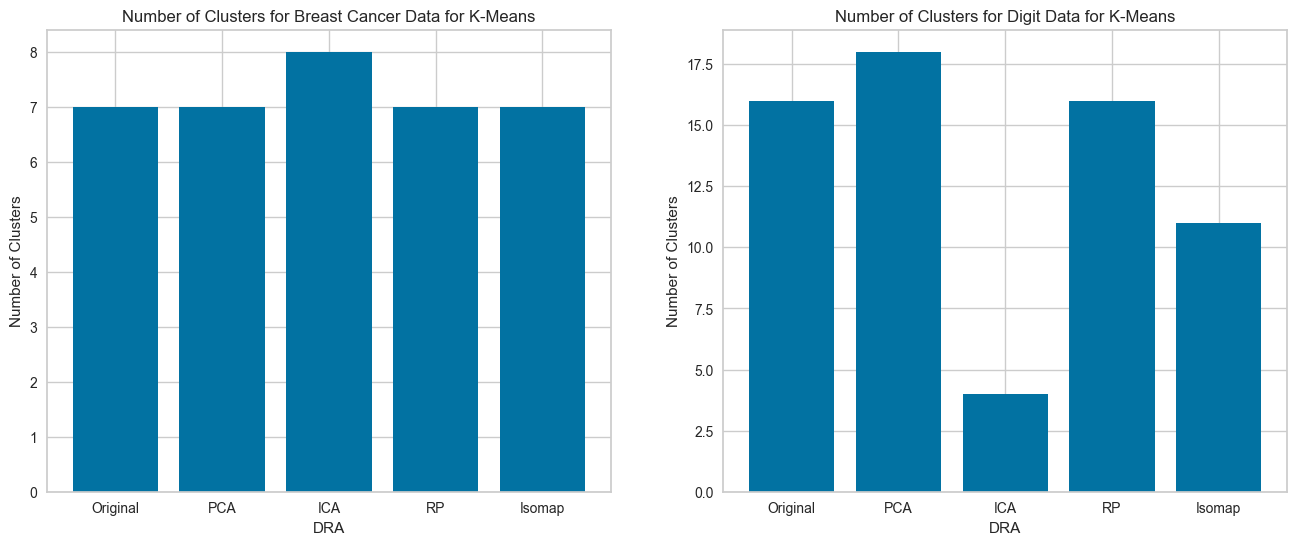

In [150]:
# Viz num clusters
fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(121)
ax.bar(["Original", "PCA", "ICA", "RP", "Isomap"], [k1, k_pca1, k_ica1, k_rp1, k_iso1])
ax.set_title("Number of Clusters for " + dataname1 + " for K-Means")
ax.set_xlabel("DRA")
ax.set_ylabel("Number of Clusters")

ax2 = fig.add_subplot(122)
ax2.bar(["Original", "PCA", "ICA", "RP", "Isomap"], [k2, k_pca2, k_ica2, k_rp2, k_iso2])
ax2.set_title("Number of Clusters for " + dataname2 + " for K-Means")
ax2.set_xlabel("DRA")
ax2.set_ylabel("Number of Clusters")

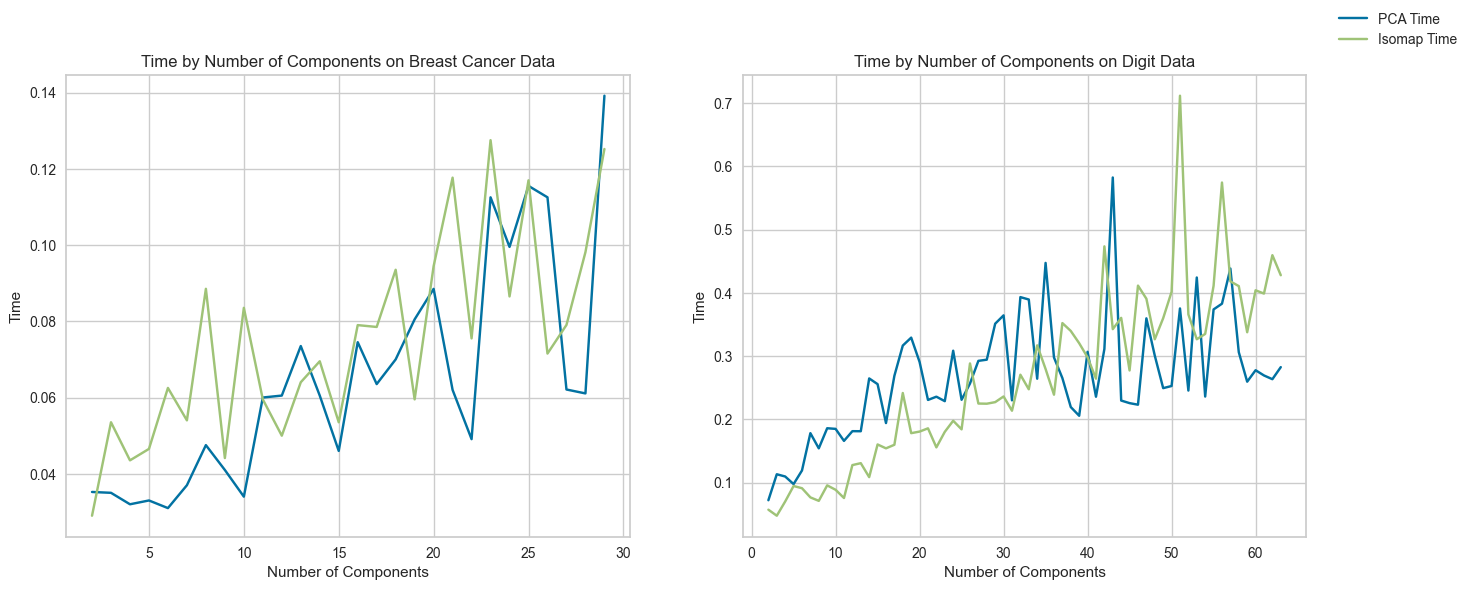

In [168]:
# Viz t-SNE selected data
fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(121)
ax.plot(np.arange(len(pca_time1)) + startIndex, pca_time1)
ax.plot(np.arange(len(iso_time1)) + startIndex, iso_time1)
ax.set_title("Time by Number of Components on " + dataname1)
ax.set_xlabel("Number of Components")
ax.set_ylabel("Time")

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(len(pca_time2)) + startIndex, pca_time2)
ax2.plot(np.arange(len(iso_time2)) + startIndex, iso_time2)
ax2.set_title("Time by Number of Components on " + dataname2)
ax2.set_xlabel("Number of Components")
ax2.set_ylabel("Time")

fig.legend(["PCA Time", "Isomap Time"])

In [123]:
# t-SNE reduction with selected datasets.
tsne_data1_pca = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5, random_state=1).fit_transform(pca_data1)
tsne_data1_iso = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5, random_state=1).fit_transform(iso_data1)

tsne_data2_pca = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5, random_state=1).fit_transform(pca_data2)
tsne_data2_iso = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5, random_state=1).fit_transform(iso_data2)

tsne_data1 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5, random_state=1).fit_transform(data1_train)
tsne_data2 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5, random_state=1).fit_transform(data2_train)

Text(0, 0.5, 'Feature 1')

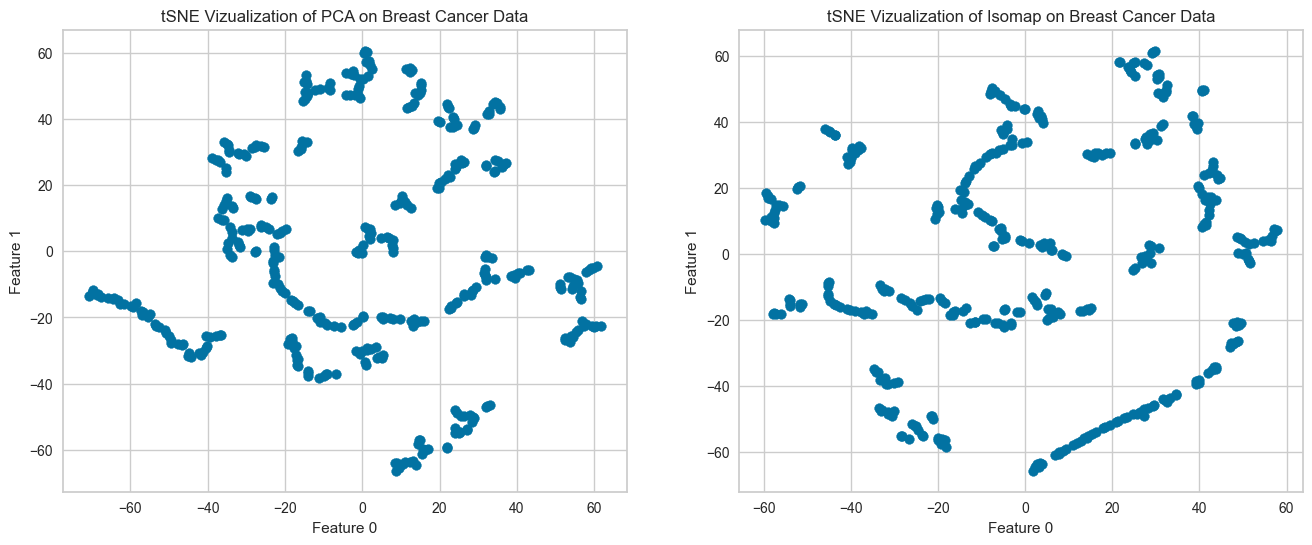

In [124]:
# Viz t-SNE selected data
fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(121)
ax.scatter(tsne_data1_pca.T[0], tsne_data1_pca.T[1])
ax.set_title("tSNE Vizualization of PCA on " + dataname1)
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")

ax2 = fig.add_subplot(122)
ax2.scatter(tsne_data1_iso.T[0], tsne_data1_iso.T[1])
ax2.set_title("tSNE Vizualization of Isomap on " + dataname1)
ax2.set_xlabel("Feature 0")
ax2.set_ylabel("Feature 1")

Text(0, 0.5, 'Feature 1')

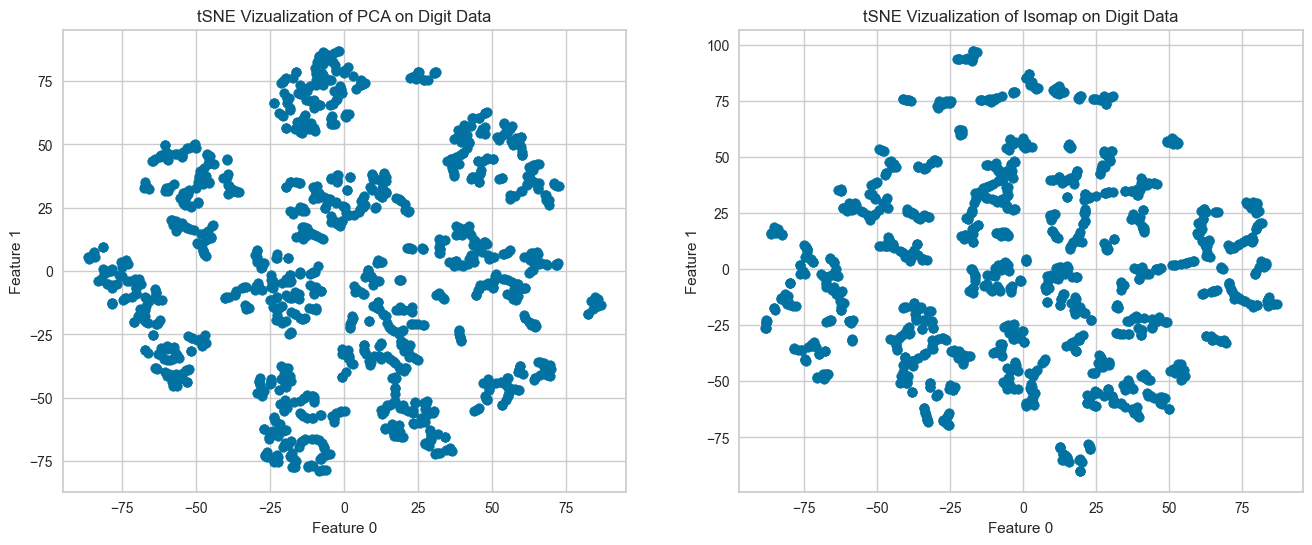

In [125]:
# Viz t-SNE selected data
fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(121)
ax.scatter(tsne_data2_pca.T[0], tsne_data2_pca.T[1])
ax.set_title("tSNE Vizualization of PCA on " + dataname2)
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")

ax2 = fig.add_subplot(122)
ax2.scatter(tsne_data2_iso.T[0], tsne_data2_iso.T[1])
ax2.set_title("tSNE Vizualization of Isomap on " + dataname2)
ax2.set_xlabel("Feature 0")
ax2.set_ylabel("Feature 1")

Text(0, 0.5, 'Feature 1')

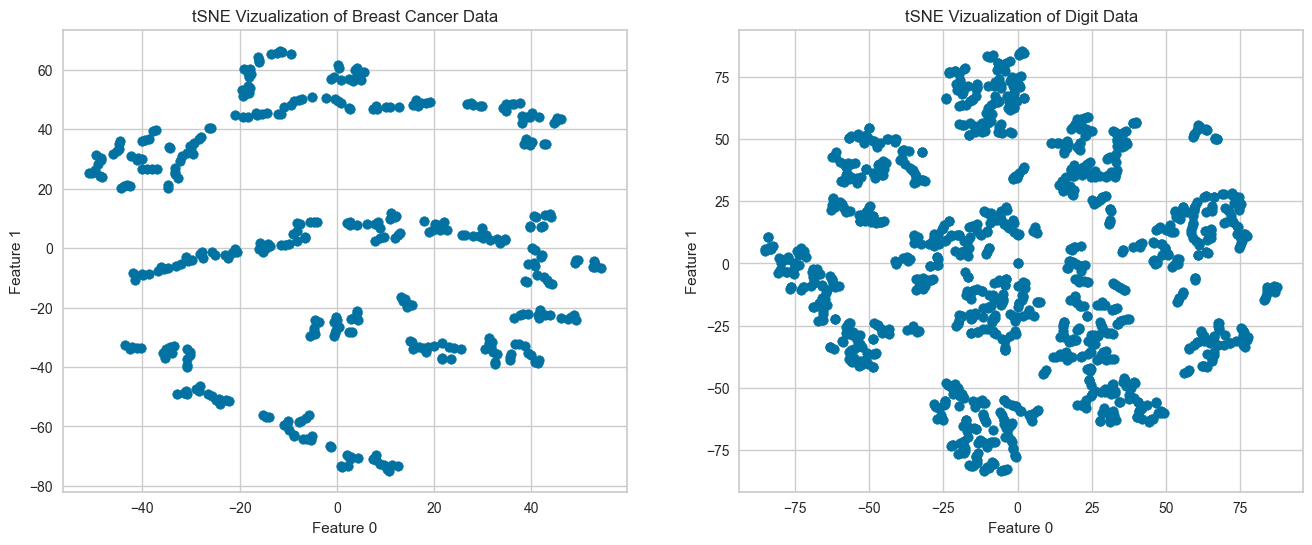

In [126]:
# Viz t-SNE selected data
fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(121)
ax.scatter(tsne_data1.T[0], tsne_data1.T[1])
ax.set_title("tSNE Vizualization of " + dataname1)
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")

ax2 = fig.add_subplot(122)
ax2.scatter(tsne_data2.T[0], tsne_data2.T[1])
ax2.set_title("tSNE Vizualization of " + dataname2)
ax2.set_xlabel("Feature 0")
ax2.set_ylabel("Feature 1")

### Refitting with Reduced Data

In [127]:
# Configure EM, DRA
pca_em1Pred = GaussianMixture(n_components=pca_gmm1, random_state=1).fit_predict(pca_data1)
pca_em2Pred = GaussianMixture(n_components=pca_gmm2, random_state=1).fit_predict(pca_data2)

ica_em1Pred = GaussianMixture(n_components=ica_gmm1, random_state=1).fit_predict(ica_data1)
ica_em2Pred = GaussianMixture(n_components=ica_gmm2, random_state=1).fit_predict(ica_data2)

rp_em1Pred = GaussianMixture(n_components=rp_gmm1, random_state=1).fit_predict(rp_data1)
rp_em2Pred = GaussianMixture(n_components=rp_gmm2, random_state=1).fit_predict(rp_data2)

iso_em1Pred = GaussianMixture(n_components=iso_gmm1, random_state=1).fit_predict(iso_data1)
iso_em2Pred = GaussianMixture(n_components=iso_gmm2, random_state=1).fit_predict(iso_data2)

In [128]:
# Configure k-Means, DRA
pca_km1Pred = KMeans(n_clusters=k_pca1).fit_predict(pca_data1)
pca_km2Pred = KMeans(n_clusters=k_pca2).fit_predict(pca_data2)

ica_km1Pred = KMeans(n_clusters=k_ica1).fit_predict(ica_data1)
ica_km2Pred = KMeans(n_clusters=k_ica2).fit_predict(ica_data2)

rp_km1Pred = KMeans(n_clusters=k_rp1).fit_predict(rp_data1)
rp_km2Pred = KMeans(n_clusters=k_rp2).fit_predict(rp_data2)

iso_km1Pred = KMeans(n_clusters=k_iso1).fit_predict(iso_data1)
iso_km2Pred = KMeans(n_clusters=k_iso2).fit_predict(iso_data2)

C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

In [129]:
# Accuracies
pca_em1Accuracy = homogeneity_score(pca_em1Pred, target1_train)
pca_em2Accuracy = homogeneity_score(pca_em2Pred, target2_train)
pca_km1Accuracy = homogeneity_score(pca_km1Pred, target1_train)
pca_km2Accuracy = homogeneity_score(pca_km2Pred, target2_train)

ica_em1Accuracy = homogeneity_score(ica_em1Pred, target1_train)
ica_em2Accuracy = homogeneity_score(ica_em2Pred, target2_train)
ica_km1Accuracy = homogeneity_score(ica_km1Pred, target1_train)
ica_km2Accuracy = homogeneity_score(ica_km2Pred, target2_train)

rp_em1Accuracy = homogeneity_score(rp_em1Pred, target1_train)
rp_em2Accuracy = homogeneity_score(rp_em2Pred, target2_train)
rp_km1Accuracy = homogeneity_score(rp_km1Pred, target1_train)
rp_km2Accuracy = homogeneity_score(rp_km2Pred, target2_train)

iso_em1Accuracy = homogeneity_score(iso_em1Pred, target1_train)
iso_em2Accuracy = homogeneity_score(iso_em2Pred, target2_train)
iso_km1Accuracy = homogeneity_score(iso_km1Pred, target1_train)
iso_km2Accuracy = homogeneity_score(iso_km2Pred, target2_train)

In [130]:
print(em1Accuracy, em2Accuracy, km1Accuracy, km2Accuracy)
print(pca_em1Accuracy, pca_em2Accuracy, pca_km1Accuracy, pca_km2Accuracy)
print(ica_em1Accuracy, ica_em2Accuracy, ica_km1Accuracy, ica_km2Accuracy)
print(rp_em1Accuracy, rp_em2Accuracy, rp_km1Accuracy, rp_km2Accuracy)
print(iso_em1Accuracy, iso_em2Accuracy, iso_km1Accuracy, iso_km2Accuracy)

0.5266541631054941 0.7400813320387358 0.27352187780483206 0.7163367722905876
0.687454923075729 0.7376256468392647 0.2666500802563323 0.6980117850083251
0.5915225866315753 0.2689090322451938 0.215201482515805 0.07044406280626464
0.6120686849534653 0.7784321121279686 0.2676357668157999 0.6156198436486525
0.47857157173697984 0.8920955902972274 0.27270291057621554 0.8559117114168956


Text(0, 0.5, 'axis 10')

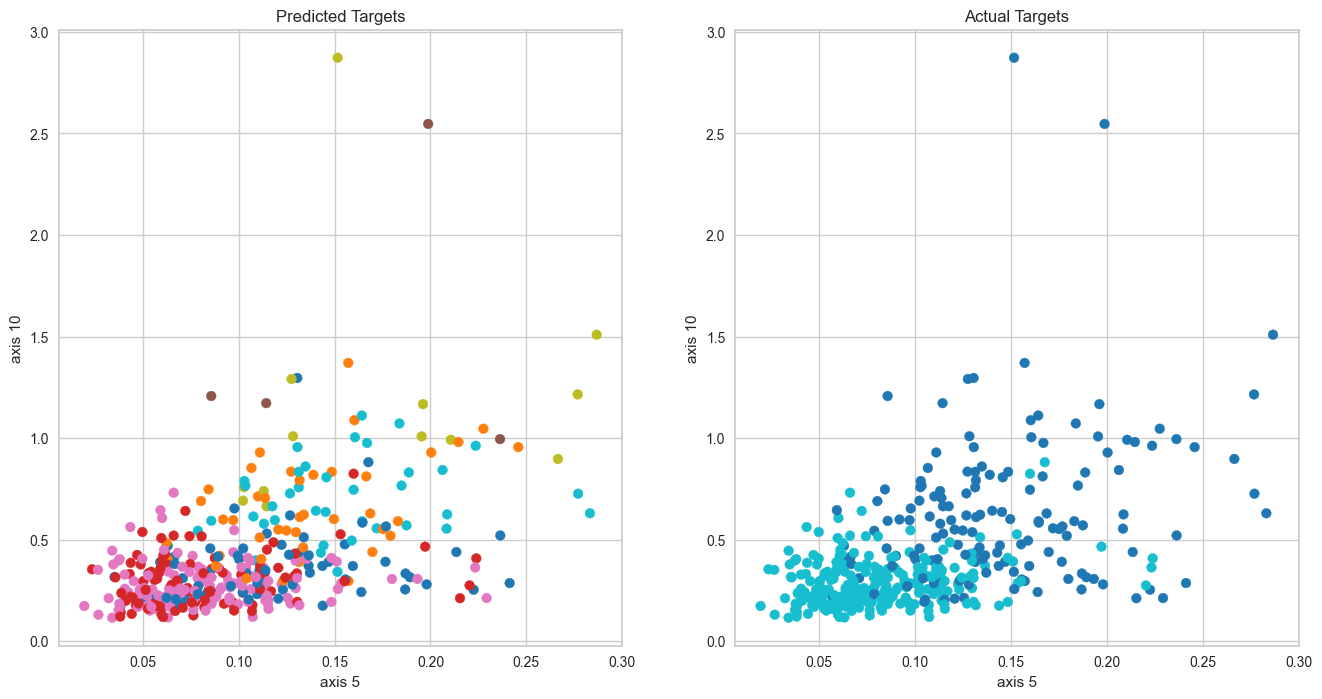

In [131]:
colors = pca_km1Pred

figData = data1_train
figTarget = target1_train
axis1 = 5
axis2 = 10

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
ax.scatter(figData.T[axis1].T, figData.T[axis2].T, c=colors, cmap='tab10')
ax.set_title("Predicted Targets")
ax.set_xlabel("axis " + str(axis1))
ax.set_ylabel("axis " + str(axis2))

ax2 = fig.add_subplot(122)
ax2.scatter(figData.T[axis1].T, figData.T[axis2].T, c=figTarget, cmap='tab10')
ax2.set_title("Actual Targets")
ax2.set_xlabel("axis " + str(axis1))
ax2.set_ylabel("axis " + str(axis2))

Text(0, 0.5, 'Accuracy')

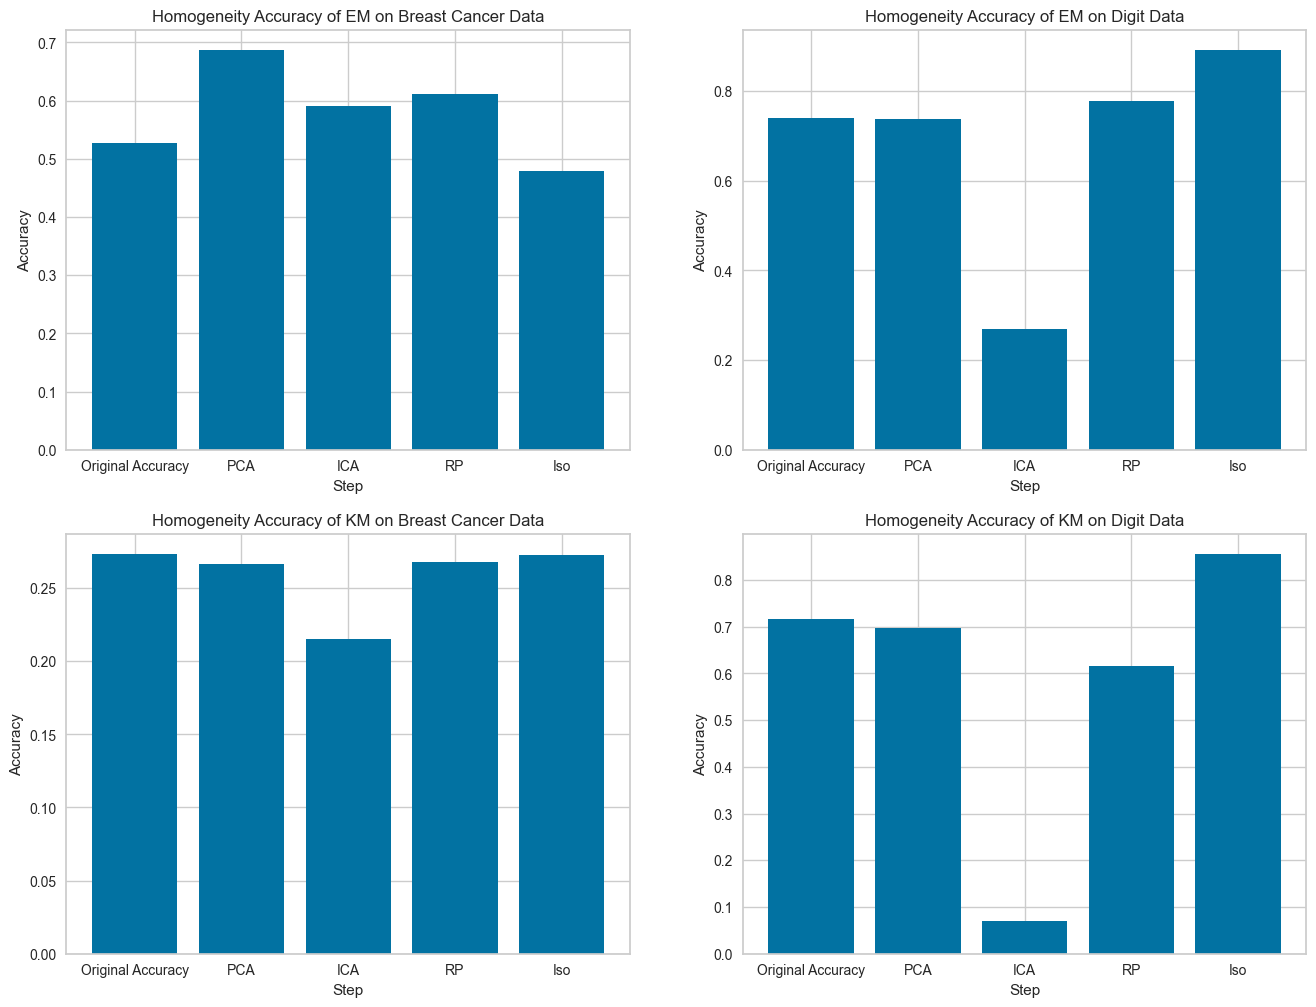

In [132]:
fig = plt.figure(figsize=(16, 12))

ax = fig.add_subplot(221)
ax.bar(["Original Accuracy", "PCA", "ICA", "RP", "Iso"], [em1Accuracy, pca_em1Accuracy, ica_em1Accuracy, rp_em1Accuracy, iso_em1Accuracy])
ax.set_title("Homogeneity Accuracy of EM on " + dataname1)
ax.set_xlabel("Step")
ax.set_ylabel("Accuracy")

ax2 = fig.add_subplot(222)
ax2.bar(["Original Accuracy", "PCA", "ICA", "RP", "Iso"], [em2Accuracy, pca_em2Accuracy, ica_em2Accuracy, rp_em2Accuracy, iso_em2Accuracy])
ax2.set_title("Homogeneity Accuracy of EM on " + dataname2)
ax2.set_xlabel("Step")
ax2.set_ylabel("Accuracy")

ax3 = fig.add_subplot(223)
ax3.bar(["Original Accuracy", "PCA", "ICA", "RP", "Iso"], [km1Accuracy, pca_km1Accuracy, ica_km1Accuracy, rp_km1Accuracy, iso_km1Accuracy])
ax3.set_title("Homogeneity Accuracy of KM on " + dataname1)
ax3.set_xlabel("Step")
ax3.set_ylabel("Accuracy")

ax4 = fig.add_subplot(224)
ax4.bar(["Original Accuracy", "PCA", "ICA", "RP", "Iso"], [km2Accuracy, pca_km2Accuracy, ica_km2Accuracy, rp_km2Accuracy, iso_km2Accuracy])
ax4.set_title("Homogeneity Accuracy of KM on " + dataname2)
ax4.set_xlabel("Step")
ax4.set_ylabel("Accuracy")

Text(0, 0.5, 'Feature 1')

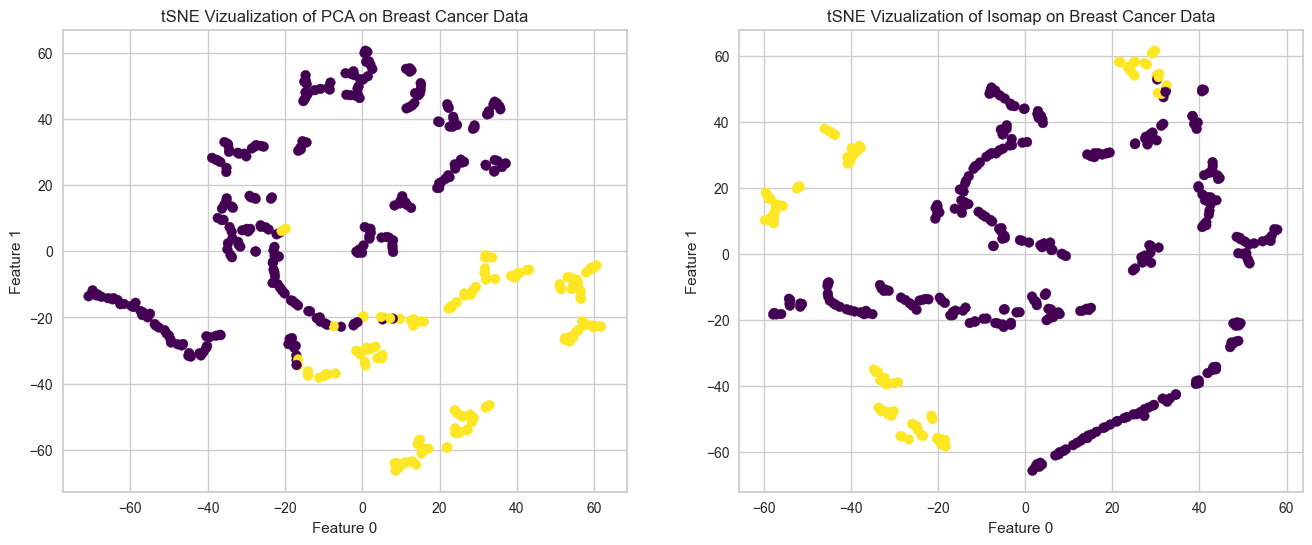

In [133]:
# Viz t-SNE selected data
fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(121)
ax.scatter(tsne_data1_pca.T[0], tsne_data1_pca.T[1], c=pca_em1Pred, cmap='viridis')
ax.set_title("tSNE Vizualization of PCA on " + dataname1)
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")

ax2 = fig.add_subplot(122)
ax2.scatter(tsne_data1_iso.T[0], tsne_data1_iso.T[1], c=iso_em1Pred, cmap='viridis')
ax2.set_title("tSNE Vizualization of Isomap on " + dataname1)
ax2.set_xlabel("Feature 0")
ax2.set_ylabel("Feature 1")

Text(0, 0.5, 'Feature 1')

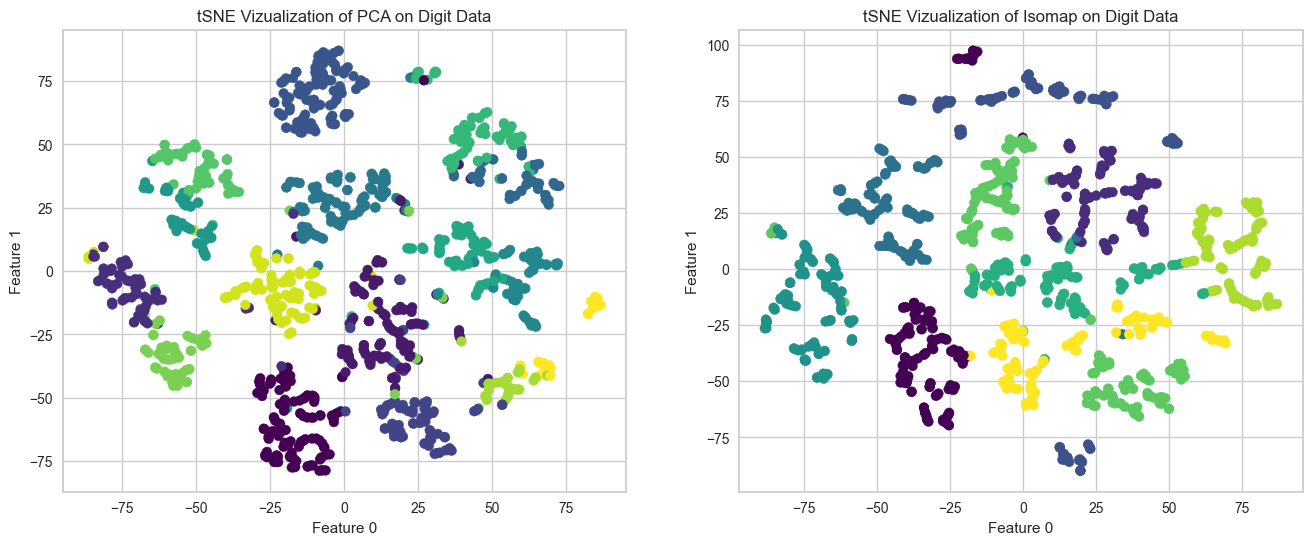

In [134]:
# Viz t-SNE selected data
fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(121)
ax.scatter(tsne_data2_pca.T[0], tsne_data2_pca.T[1], c=pca_em2Pred, cmap='viridis')
ax.set_title("tSNE Vizualization of PCA on " + dataname2)
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")

ax2 = fig.add_subplot(122)
ax2.scatter(tsne_data2_iso.T[0], tsne_data2_iso.T[1], c=iso_em2Pred, cmap='viridis')
ax2.set_title("tSNE Vizualization of Isomap on " + dataname2)
ax2.set_xlabel("Feature 0")
ax2.set_ylabel("Feature 1")

Text(0, 0.5, 'Feature 1')

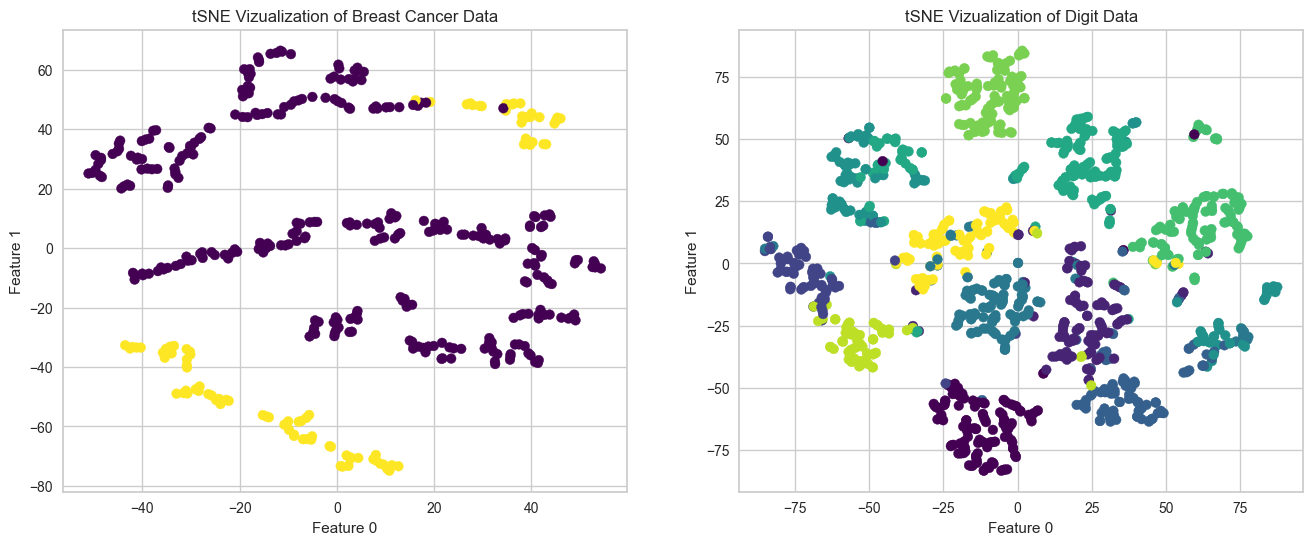

In [135]:
# Viz t-SNE selected data
fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(121)
ax.scatter(tsne_data1.T[0], tsne_data1.T[1], c=em1Pred, cmap='viridis')
ax.set_title("tSNE Vizualization of " + dataname1)
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")

ax2 = fig.add_subplot(122)
ax2.scatter(tsne_data2.T[0], tsne_data2.T[1], c=em2Pred, cmap='viridis')
ax2.set_title("tSNE Vizualization of " + dataname2)
ax2.set_xlabel("Feature 0")
ax2.set_ylabel("Feature 1")

### Neural Network fitting

In [136]:
# Define NN

model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(data1_train, target1_train)
model.score(data1_test, target1_test)
lossCurve1 = model.loss_curve_
valScore1 = model.validation_scores_

model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(data2_train, target2_train)
model.score(data2_test, target2_test)
lossCurve2 = model.loss_curve_
valScore2 = model.validation_scores_

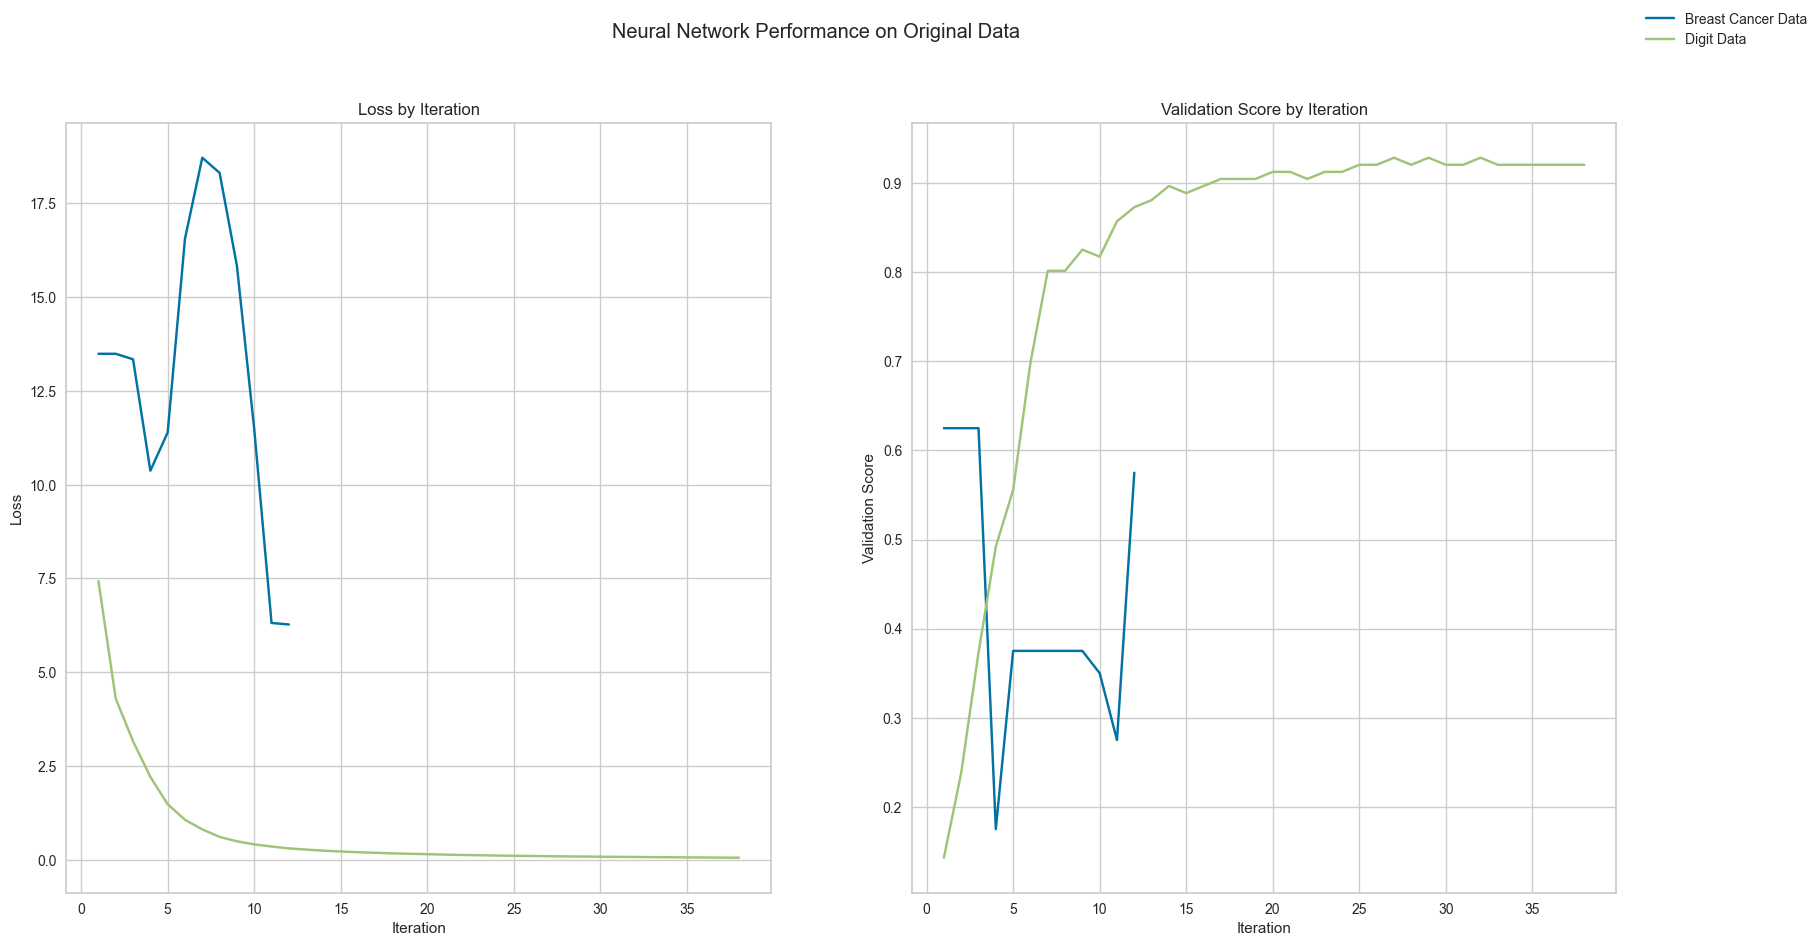

In [137]:
# Orig NN Viz

fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(121)
ax.plot(np.arange(len(lossCurve1)) + 1, lossCurve1)
ax.plot(np.arange(len(lossCurve2)) + 1, lossCurve2)
ax.set_title("Loss by Iteration")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(len(valScore1)) + 1, valScore1)
ax2.plot(np.arange(len(valScore2)) + 1, valScore2)
ax2.set_title("Validation Score by Iteration")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Validation Score")

fig.suptitle("Neural Network Performance on Original Data")
fig.legend([dataname1, dataname2])

In [138]:
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True)
train_sizes = np.arange(20, 81)/100
train_size_abs, train_scores, test_scores = learning_curve(model, data1_train, target1_train, train_sizes=train_sizes)

Text(0, 0.5, 'Test Score')

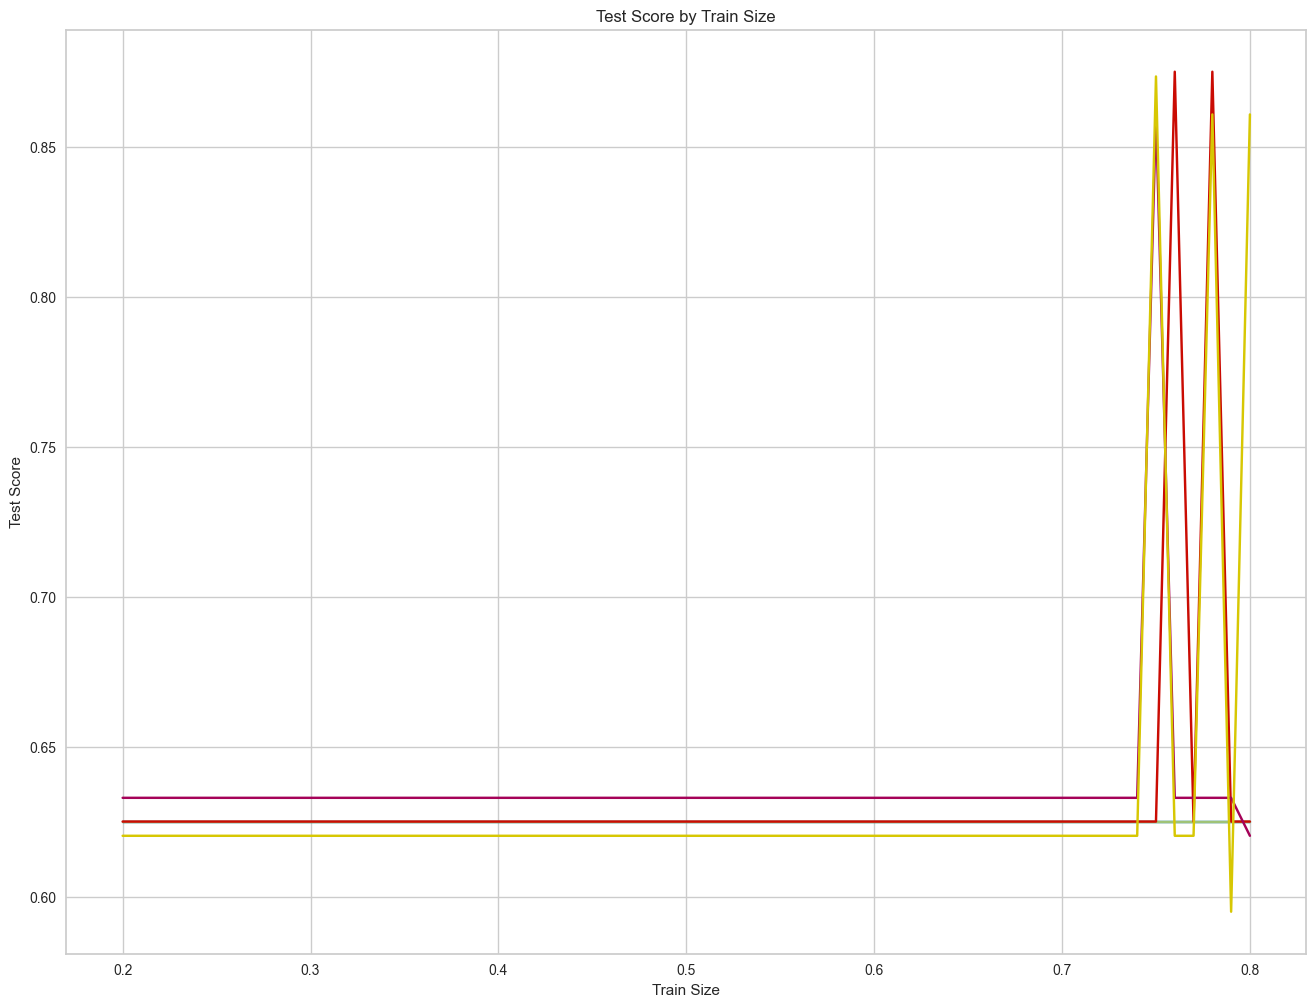

In [139]:
fig = plt.figure(figsize=(16, 12))

ax = fig.add_subplot(111)
ax.plot(train_sizes, test_scores)
ax.set_title("Test Score by Train Size")
ax.set_xlabel("Train Size")
ax.set_ylabel("Test Score")

In [140]:
# Neural Net on Reduced Data

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(data1_train, target1_train)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(data1_train, target1_train)
model.score(data1_test, target1_test)
lossCurve1 = model.loss_curve_
valScore1 = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(data2_train, target2_train)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(data2_train, target2_train)
model.score(data2_test, target2_test)
lossCurve2 = model.loss_curve_
valScore2 = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(pca_data1, target1_train)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(pca_data1, target1_train)
model.score(pca_data1_test, target1_test)
pca_lossCurve1 = model.loss_curve_
pca_valScore1 = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(pca_data2, target2_train)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(pca_data2, target2_train)
model.score(pca_data2_test, target2_test)
pca_lossCurve2 = model.loss_curve_
pca_valScore2 = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(ica_data1, target1_train)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(ica_data1, target1_train)
model.score(ica_data1_test, target1_test)
ica_lossCurve1 = model.loss_curve_
ica_valScore1 = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(ica_data2, target2_train)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(ica_data2, target2_train)
model.score(ica_data2_test, target2_test)
ica_lossCurve2 = model.loss_curve_
ica_valScore2 = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(rp_data1, target1_train)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(rp_data1, target1_train)
model.score(rp_data1_test, target1_test)
rp_lossCurve1 = model.loss_curve_
rp_valScore1 = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(rp_data2, target2_train)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(rp_data2, target2_train)
model.score(rp_data2_test, target2_test)
rp_lossCurve2 = model.loss_curve_
rp_valScore2 = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(iso_data1, target1_train)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(iso_data1, target1_train)
model.score(iso_data1_test, target1_test)
iso_lossCurve1 = model.loss_curve_
iso_valScore1 = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(iso_data2, target2_train)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(iso_data2, target2_train)
model.score(iso_data2_test, target2_test)
iso_lossCurve2 = model.loss_curve_
iso_valScore2 = model.validation_scores_

59.8 ms ± 2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
421 ms ± 36.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
72.8 ms ± 2.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
282 ms ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
50.1 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
401 ms ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
50.2 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
355 ms ± 23.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
60 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
133 ms ± 3.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


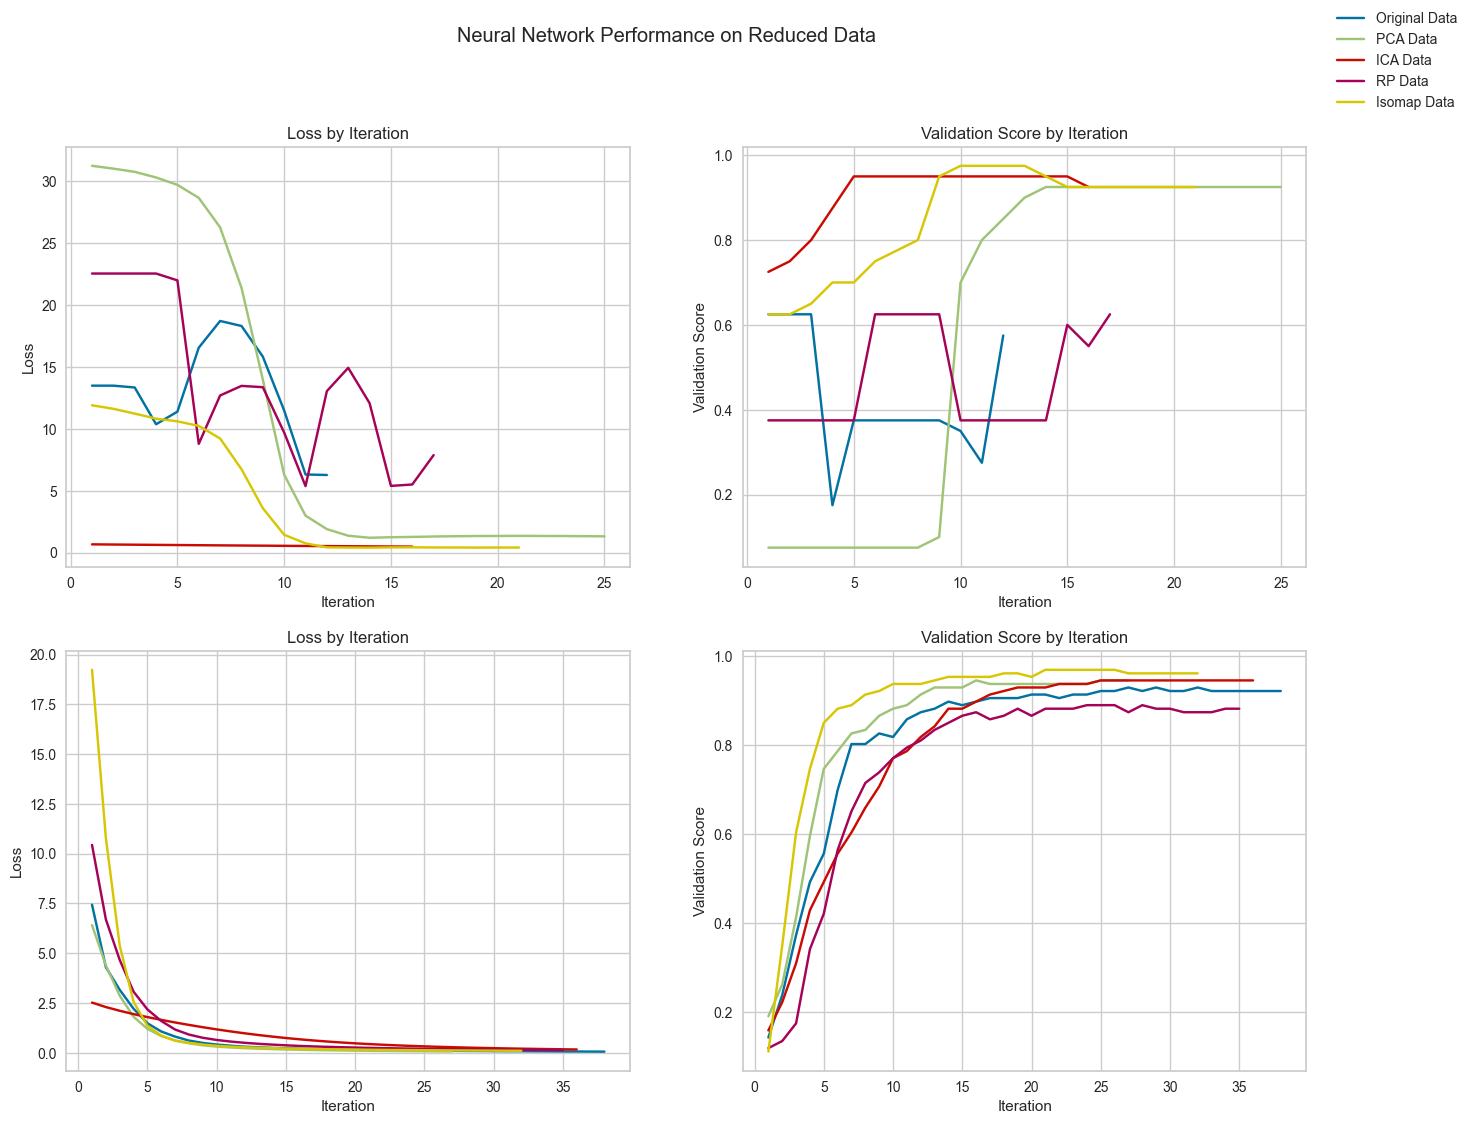

In [141]:
# DRA NN Viz

fig = plt.figure(figsize=(16, 12))

ax = fig.add_subplot(221)
ax.plot(np.arange(len(lossCurve1)) + 1, lossCurve1)
ax.plot(np.arange(len(pca_lossCurve1)) + 1, pca_lossCurve1)
ax.plot(np.arange(len(ica_lossCurve1)) + 1, ica_lossCurve1)
ax.plot(np.arange(len(rp_lossCurve1)) + 1, rp_lossCurve1)
ax.plot(np.arange(len(iso_lossCurve1)) + 1, iso_lossCurve1)
ax.set_title("Loss by Iteration")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")

ax2 = fig.add_subplot(222)
ax2.plot(np.arange(len(valScore1)) + 1, valScore1)
ax2.plot(np.arange(len(pca_valScore1)) + 1, pca_valScore1)
ax2.plot(np.arange(len(ica_valScore1)) + 1, ica_valScore1)
ax2.plot(np.arange(len(rp_valScore1)) + 1, rp_valScore1)
ax2.plot(np.arange(len(iso_valScore1)) + 1, iso_valScore1)
ax2.set_title("Validation Score by Iteration")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Validation Score")

ax3 = fig.add_subplot(223)
ax3.plot(np.arange(len(lossCurve2)) + 1, lossCurve2)
ax3.plot(np.arange(len(pca_lossCurve2)) + 1, pca_lossCurve2)
ax3.plot(np.arange(len(ica_lossCurve2)) + 1, ica_lossCurve2)
ax3.plot(np.arange(len(rp_lossCurve2)) + 1, rp_lossCurve2)
ax3.plot(np.arange(len(iso_lossCurve2)) + 1, iso_lossCurve2)
ax3.set_title("Loss by Iteration")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Loss")

ax4 = fig.add_subplot(224)
ax4.plot(np.arange(len(valScore2)) + 1, valScore2)
ax4.plot(np.arange(len(pca_valScore2)) + 1, pca_valScore2)
ax4.plot(np.arange(len(ica_valScore2)) + 1, ica_valScore2)
ax4.plot(np.arange(len(rp_valScore2)) + 1, rp_valScore2)
ax4.plot(np.arange(len(iso_valScore2)) + 1, iso_valScore2)
ax4.set_title("Validation Score by Iteration")
ax4.set_xlabel("Iteration")
ax4.set_ylabel("Validation Score")

fig.suptitle("Neural Network Performance on Reduced Data")
fig.legend(["Original Data", "PCA Data", "ICA Data", "RP Data", "Isomap Data"])

### NN Fitting on DRA with Clusters as Features

In [142]:
# Clusters as Features

data1_preds = np.vstack([em1Pred, km1Pred]).T
data2_preds = np.vstack([em2Pred, km2Pred]).T

data1_boosted = np.hstack([data1_train, data1_preds])
data2_boosted = np.hstack([data2_train, data2_preds])

pca_data1_boosted = np.hstack([pca_data1, data1_preds])
pca_data2_boosted = np.hstack([pca_data2, data2_preds])

ica_data1_boosted = np.hstack([ica_data1, data1_preds])
ica_data2_boosted = np.hstack([ica_data2, data2_preds])

rp_data1_boosted = np.hstack([rp_data1, data1_preds])
rp_data2_boosted = np.hstack([rp_data2, data2_preds])

iso_data1_boosted = np.hstack([iso_data1, data1_preds])
iso_data2_boosted = np.hstack([iso_data2, data2_preds])

data1_test_preds = np.vstack([em1Pred_test, km1Pred_test]).T
data2_test_preds = np.vstack([em2Pred_test, km2Pred_test]).T

data1_test_boosted = np.hstack([data1_test, data1_test_preds])
data2_test_boosted = np.hstack([data2_test, data2_test_preds])

pca_data1_test_boosted = np.hstack([pca_data1_test, data1_test_preds])
pca_data2_test_boosted = np.hstack([pca_data2_test, data2_test_preds])

ica_data1_test_boosted = np.hstack([ica_data1_test, data1_test_preds])
ica_data2_test_boosted = np.hstack([ica_data2_test, data2_test_preds])

rp_data1_test_boosted = np.hstack([rp_data1_test, data1_test_preds])
rp_data2_test_boosted = np.hstack([rp_data2_test, data2_test_preds])

iso_data1_test_boosted = np.hstack([iso_data1_test, data1_test_preds])
iso_data2_test_boosted = np.hstack([iso_data2_test, data2_test_preds])

In [143]:
# Neural Net on Reduced Data

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(data1_boosted, target1_train)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(data1_boosted, target1_train)
model.score(data1_test_boosted, target1_test)
lossCurve1_boosted = model.loss_curve_
valScore1_boosted = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(data2_boosted, target2_train)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(data2_boosted, target2_train)
model.score(data2_test_boosted, target2_test)
lossCurve2_boosted = model.loss_curve_
valScore2_boosted = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(pca_data1_boosted, target1_train)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(pca_data1_boosted, target1_train)
model.score(pca_data1_test_boosted, target1_test)
pca_lossCurve1_boosted = model.loss_curve_
pca_valScore1_boosted = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(pca_data2_boosted, target2_train)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(pca_data2_boosted, target2_train)
model.score(pca_data2_test_boosted, target2_test)
pca_lossCurve2_boosted = model.loss_curve_
pca_valScore2_boosted = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(ica_data1_boosted, target1_train)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(ica_data1_boosted, target1_train)
model.score(ica_data1_test_boosted, target1_test)
ica_lossCurve1_boosted = model.loss_curve_
ica_valScore1_boosted = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(ica_data2_boosted, target2_train)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(ica_data2_boosted, target2_train)
model.score(ica_data2_test_boosted, target2_test)
ica_lossCurve2_boosted = model.loss_curve_
ica_valScore2_boosted = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(rp_data1_boosted, target1_train)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(rp_data1_boosted, target1_train)
model.score(rp_data1_test_boosted, target1_test)
rp_lossCurve1_boosted = model.loss_curve_
rp_valScore1_boosted = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(rp_data2_boosted, target2_train)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(rp_data2_boosted, target2_train)
model.score(rp_data2_test_boosted, target2_test)
rp_lossCurve2_boosted = model.loss_curve_
rp_valScore2_boosted = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(iso_data1_boosted, target1_train)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(iso_data1_boosted, target1_train)
model.score(iso_data1_test_boosted, target1_test)
iso_lossCurve1_boosted = model.loss_curve_
iso_valScore1_boosted = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(iso_data2_boosted, target2_train)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(iso_data2_boosted, target2_train)
model.score(iso_data2_test_boosted, target2_test)
iso_lossCurve2_boosted = model.loss_curve_
iso_valScore2_boosted = model.validation_scores_

57.4 ms ± 2.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
279 ms ± 19.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
104 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
253 ms ± 19.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
98.1 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
361 ms ± 25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
36.3 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
430 ms ± 36.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
52.4 ms ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
106 ms ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


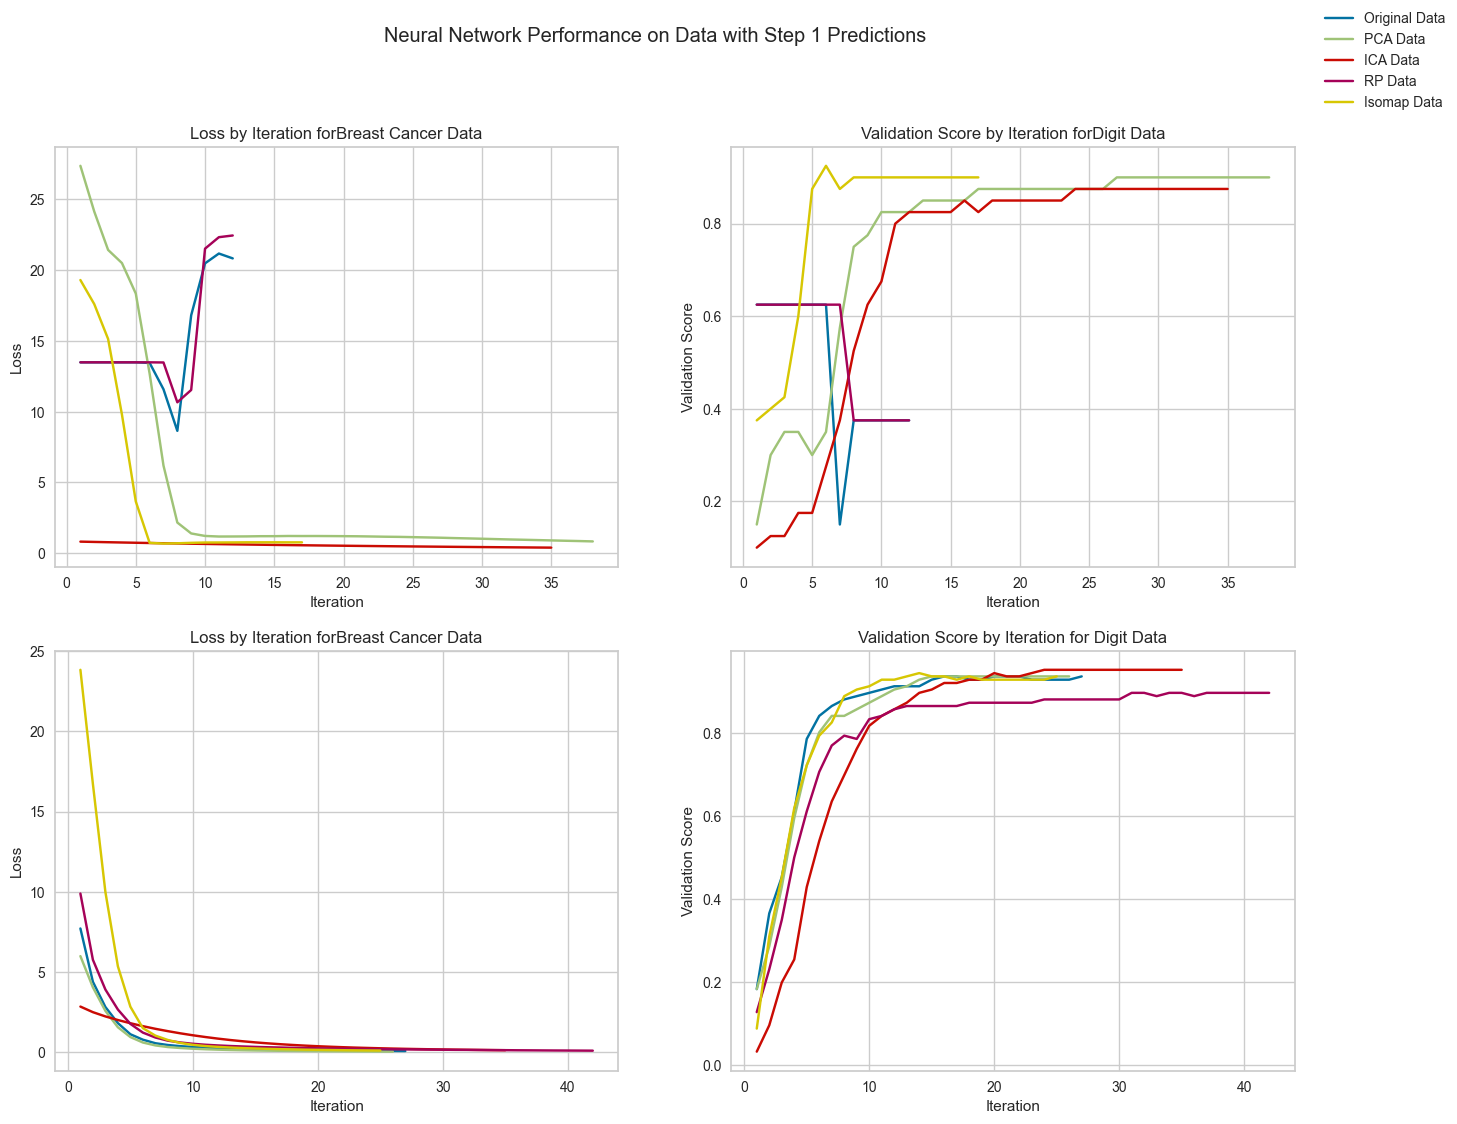

In [144]:
# DRA NN Viz

fig = plt.figure(figsize=(16, 12))

ax = fig.add_subplot(221)
ax.plot(np.arange(len(lossCurve1_boosted)) + 1, lossCurve1_boosted)
ax.plot(np.arange(len(pca_lossCurve1_boosted)) + 1, pca_lossCurve1_boosted)
ax.plot(np.arange(len(ica_lossCurve1_boosted)) + 1, ica_lossCurve1_boosted)
ax.plot(np.arange(len(rp_lossCurve1_boosted)) + 1, rp_lossCurve1_boosted)
ax.plot(np.arange(len(iso_lossCurve1_boosted)) + 1, iso_lossCurve1_boosted)
ax.set_title("Loss by Iteration for" + dataname1)
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")

ax2 = fig.add_subplot(222)
ax2.plot(np.arange(len(valScore1_boosted)) + 1, valScore1_boosted)
ax2.plot(np.arange(len(pca_valScore1_boosted)) + 1, pca_valScore1_boosted)
ax2.plot(np.arange(len(ica_valScore1_boosted)) + 1, ica_valScore1_boosted)
ax2.plot(np.arange(len(rp_valScore1_boosted)) + 1, rp_valScore1_boosted)
ax2.plot(np.arange(len(iso_valScore1_boosted)) + 1, iso_valScore1_boosted)
ax2.set_title("Validation Score by Iteration for" + dataname2)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Validation Score")

ax3 = fig.add_subplot(223)
ax3.plot(np.arange(len(lossCurve2_boosted)) + 1, lossCurve2_boosted)
ax3.plot(np.arange(len(pca_lossCurve2_boosted)) + 1, pca_lossCurve2_boosted)
ax3.plot(np.arange(len(ica_lossCurve2_boosted)) + 1, ica_lossCurve2_boosted)
ax3.plot(np.arange(len(rp_lossCurve2_boosted)) + 1, rp_lossCurve2_boosted)
ax3.plot(np.arange(len(iso_lossCurve2_boosted)) + 1, iso_lossCurve2_boosted)
ax3.set_title("Loss by Iteration for" + dataname1)
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Loss")

ax4 = fig.add_subplot(224)
ax4.plot(np.arange(len(valScore2_boosted)) + 1, valScore2_boosted)
ax4.plot(np.arange(len(pca_valScore2_boosted)) + 1, pca_valScore2_boosted)
ax4.plot(np.arange(len(ica_valScore2_boosted)) + 1, ica_valScore2_boosted)
ax4.plot(np.arange(len(rp_valScore2_boosted)) + 1, rp_valScore2_boosted)
ax4.plot(np.arange(len(iso_valScore2_boosted)) + 1, iso_valScore2_boosted)
ax4.set_title("Validation Score by Iteration for " + dataname2)
ax4.set_xlabel("Iteration")
ax4.set_ylabel("Validation Score")

fig.suptitle("Neural Network Performance on Data with Step 1 Predictions")
fig.legend(["Original Data", "PCA Data", "ICA Data", "RP Data", "Isomap Data"])